<a href="https://colab.research.google.com/github/Raanank10/Instagram-s-influencers/blob/Eladk_20211007/Instagram_influencers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Instagram_influencers**

# Global Parameters

In [908]:
path_part0 = 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/ai_posts_analysis_data.xlsx'
fname = 'ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/ai_posts_analysis_data.xlsx'
# fname = 'https://github.com/Raanank10/Instagram-s-influencers/blob/main/ai_posts_analysis_data.xlsx'

path_part1= 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/project_part1.csv'
path_part2= 'https://raw.githubusercontent.com/Raanank10/Instagram-s-influencers/main/project_part2.csv'

train_size = 0.75
rand_state = 990
sigma = 3
Min_followers = 500

In [909]:
# Bining
bin_labels=['Low','Medium','High', 'Very High','Extreme']

# Get the Data

In [910]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno
import xgboost as xgb

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report # elad 20210708
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.preprocessing import OrdinalEncoder # elad 20210911

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

## Concate the 3 files

In [911]:
df_part0 = pd.read_csv(path_part0, index_col=0)  
print(f'data len of df_part0 = {len(df_part0)}')
df_part0.head(2)

data len of df_part0 = 4792


,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,2530600951335029174,CMegChUlwm2,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, 2021.",FFP2 MADE IN ITALY????????#ffp2mask#italianstyle#madeinitaly????????#produzionepropria#produttori#farmacie#farmacieitaliane#parafarmacia#mascherinelavabili#mask#ffp2,NaN,NaN,NaN,1615891163,"Clothing, Apparel, Text, Money, Collage, Advertisement, Poster",education,movies,business,https://instagram.fdok2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.180.1440.1440a/s640x640/160374486_2823675294516254_158720847037227315_n.jpg?tp=1&_nc_ht=instagram.fdok2-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=fXOFeWEt3dcAX9moTcA&edm=ABfd0MgBAAAA&ccb=7-4&oh=cc36e9f840bc93314fcc9e76c9e4b8c6&oe=60DA4B27&_nc_sid=7bff83,no,no,no,NaN,NaN
1919,8210198494,pamela.latorre.73,Pamela La Torre,309,2595285287724490476,CQETjgBnZ7s,55,23,25.24,https://www.instagram.com/p/CQETjgBnZ7s,"Photo by Pamela La Torre on June 13, 2021. May be an image of one or more people, people standing and indoor.",Prima comunione Giorgio,Santissimo Crocifisso,"Taranto, Italy",NaN,1623602137,"Person, Human, Photographer, Photography, Photo, Furniture, Shoe, Clothing, Footwear, Apparel, Interior Design, Indoors",news,arts_entertainment,style_fashion,https://instagram.fhel3-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/131454075_203114518334788_1962979990399529842_n.jpg?tp=1&_nc_ht=instagram.fhel3-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=XmsE8bbC2cIAX-0rYFU&edm=ABfd0MgBAAAA&ccb=7-4&oh=4ca96de8a58eafc0ac1e2eea47d28236&oe=60D9DF1A&_nc_sid=7bff83,no,no,no,NaN,NaN


In [912]:
df_part1 = pd.read_csv(path_part1, index_col=0) 
print(f'data len of df_part1 = {len(df_part1)}') 
df_part1.head(2)

data len of df_part1 = 18586


,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
24897,47655063851,_color_pal_ette,Asty,17,2.660000e+18,CTegsqAhtEs,959,0,5641.18,https://www.instagram.com/p/CTegsqAhtEs,NaN,......(50:7)\n....\n#islam#quran#islamic#verse#quranverse#nature#subhanallah#muslim#reels#islamicreels#truth#mountains#ahmedalnufais#qiraat#reeloftheday#reelsinstagram#holyquran#mist,NaN,NaN,NaN,1630923941,"Vegetation, Plant, Nature, Rainforest, Outdoors, Land, Tree, Weather, Fog, Jungle, Painting, Art, Mist, Woodland, Forest, Bush, Landscape, Scenery",education,NaN,travel,https://scontent-hel3-1.cdninstagram.com/v/t51.2885-15/sh0.08/e35/c0.280.720.720a/s640x640/241390863_566725341049399_4464518408404712824_n.jpg?_nc_ht=scontent-hel3-1.cdninstagram.com&_nc_cat=107&_nc_ohc=ha3byVQANRAAX9uFuw8&edm=ABfd0MgBAAAA&ccb=7-4&oh=7b839f77160e3de879662df045a33628&oe=614DDB58&_nc_sid=7bff83,no,yes,yes,https://scontent-hel3-1.cdninstagram.com/v/t50.2886-16/241355135_2968650116724302_9211268511392989112_n.mp4?_nc_ht=scontent-hel3-1.cdninstagram.com&_nc_cat=102&_nc_ohc=lfaZh608M8YAX-ejoCg&edm=ABfd0MgBAAAA&ccb=7-4&oe=614DC35A&oh=d7c047911961f8e5a4e841daceb2dddc&_nc_sid=7bff83,1872.0
31286,47448521201,gigimakeup25,Gilliam Ibáñez ???????? makeup,157,2.660000e+18,CTsfWCeFunb,30,2147,1386.62,https://www.instagram.com/p/CTsfWCeFunb,"Photo by Gilliam Ibáñez ???????? makeup on September 11, 2021. May be an image of cosmetics and text.","???????????????? ???? SORTEO ????????????\n participa Ahora y Gana \nUna Paleta de Sombras ( 32 Colores) + Set de Brochas Profesinales de ojos + OBSEQUIO Sorpresa.\n \nCómo Participar?\n???? Sigue nuestra cuenta en Instagram @gigimakeup25 \n???? Etiqueta a 3 Amigos ( No valen famosos , etc )\n???? Dejar un comentario con el hastang #quieroganar.\n\nPuedes participar hasta el 05/10/2021 Hasta las 23:59.\nEl 06/10/2021 se publicará el nombre del feliz Ganador o Ganadora.\nTe Apuntas! ,????????\nMucha Suerte",NaN,NaN,NaN,1631392946,"Flyer, Brochure, Advertisement, Poster, Paper, Text",entertainment,style_fashion,business,https://instagram.frix2-1.fna.fbcdn.net/v/t51.2885-15/e35/241739897_285537473018070_6208727686952352391_n.jpg?_nc_ht=instagram.frix2-1.fna.fbcdn.net&_nc_cat=106&_nc_ohc=VVj13OvSavsAX_jLTaF&edm=ABfd0MgBAAAA&ccb=7-4&oh=29790167523b714e288148d65d3d0ce1&oe=6151B61D&_nc_sid=7bff83,no,no,no,NaN,NaN


In [913]:
df_part2 = pd.read_csv(path_part2, index_col=0)  
print(f'data len of df_part2 = {len(df_part2)}') 
df_part2.head(2)

data len of df_part2 = 17471


,USERID,USERNAME,FULLNAME,FOLLOWER,POST ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE LABELS,CAPTION INTEREST,ACCESSIBILITY CAPTION INTEREST,IMAGE LABEL INTEREST,IMAGE URL,COMMENT DISABLED,IS VIDEO,HAS AUDIO,VIDEO URL,VIDEO VIEW COUNT
1,,,,,,,,,,,,,,,,,,,,,,,,,,
25807,40005237207,byeonggil6734,ç ‚å²¡????????????,717,2.550000e+18,CNfe10KrHnr,31,0,4.32,https://www.instagram.com/p/CNfe10KrHnr,"Photo by ç ‚å²¡???????????? on April 10, 2021. May be an image of 1 person, beard, sitting and indoor.",ì£¼ë§ì—ëŠ” í•˜ë£¨ ìˆ˜ê³ í–ˆìŠµë‹ˆë‹¤ ë¶€ì‚°ì—ì„œ,NaN,NaN,NaN,1618071572,"Chair, Furniture, Couch, Skin, Clothing, Apparel, Person, Human, Sitting, Cushion, Footwear, Indoors, Hat, Living Room, Room, Shoe, Armchair",education,arts_entertainment,style_fashion,https://instagram.fixb1-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/170910814_741739049702462_4206717608969572137_n.jpg?_nc_ht=instagram.fixb1-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=a_5hpwC8mPsAX-S9s57&edm=ABfd0MgBAAAA&ccb=7-4&oh=7cbf9bf3791389688cdba4a7825ca78d&oe=6152D144&_nc_sid=7bff83,yes,no,no,NaN,NaN
27121,17931150200,hitmanmikey,mikey_BANGZ,6182,2.650000e+18,CS5ZWqFD3uv,242,25,4.32,https://www.instagram.com/p/CS5ZWqFD3uv,NaN,"(5-Step #Drill - #SubJazz Version)\n\n142 BPM in G Minor\n\nISRC# QZJUN2108076\n\nFor complete information regarding the production timeline of this instrumental, an electronic press kit or for writers/artists/visual content creators who desire custom created sound-beds to help you tell a story:\n\nofficial email: mikey@hitmanmikey.com\n\nUntagged Mastered .WAV & .MP3 Files / Stems and Customized Versions / Custom Requests available @:\n\nhttps://www.hitmanmikey.com/beat/mannastihl-9053229\n\n#instrumentals #",NaN,NaN,NaN,1629678866,"Poster, Advertisement, Symbol, Emblem, Logo, Trademark",arts_entertainment,NaN,business,https://instagram.fcvj4-1.fna.fbcdn.net/v/t51.2885-15/e15/240439053_577407736769807_3660906977618921919_n.jpg?_nc_ht=instagram.fcvj4-1.fna.fbcdn.net&_nc_cat=111&_nc_ohc=FMrS8eaM3c4AX_j7uZQ&edm=ABfd0MgBAAAA&ccb=7-4&oh=d1f706d41034056efc58ff0636f706d1&oe=614D92FF&_nc_sid=7bff83,no,yes,yes,https://instagram.fcvj4-1.fna.fbcdn.net/v/t50.2886-16/10000000_260626065677205_8633015125519467545_n.mp4?_nc_ht=instagram.fcvj4-1.fna.fbcdn.net&_nc_cat=109&_nc_ohc=9SPqvkLxzpcAX8oScWV&edm=ABfd0MgBAAAA&ccb=7-4&oe=614DFD4D&oh=de4d9725e550a279f140d3d260345122&_nc_sid=7bff83,3456.0


In [914]:
df = pd.concat([df_part0, df_part1, df_part2])
print(f'data len After concat all parts = {len(df)}')

data len After concat all parts = 40849


In [915]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40849 entries, 1918 to 37857
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          40849 non-null  int64  
 1   USERNAME                        40849 non-null  object 
 2   FULLNAME                        39489 non-null  object 
 3   FOLLOWER                        40849 non-null  int64  
 4   POST ID                         40849 non-null  float64
 5   SHORTCODE                       40849 non-null  object 
 6   LIKES                           40849 non-null  int64  
 7   COMMENTS                        40849 non-null  int64  
 8   ENGAGEMENT                      40849 non-null  float64
 9   URL                             40849 non-null  object 
 10  ACCESSIBILITY CAPTION           33725 non-null  object 
 11  CAPTION                         34786 non-null  object 
 12  LOCATION                     

In [916]:
print(f'data len Before = {len(df)}')
df = df[~df.index.duplicated()]
print(f'data len After  = {len(df)}')
df.info()

data len Before = 40849
data len After  = 36057
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36057 entries, 1918 to 37857
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          36057 non-null  int64  
 1   USERNAME                        36057 non-null  object 
 2   FULLNAME                        34823 non-null  object 
 3   FOLLOWER                        36057 non-null  int64  
 4   POST ID                         36057 non-null  float64
 5   SHORTCODE                       36057 non-null  object 
 6   LIKES                           36057 non-null  int64  
 7   COMMENTS                        36057 non-null  int64  
 8   ENGAGEMENT                      36057 non-null  float64
 9   URL                             36057 non-null  object 
 10  ACCESSIBILITY CAPTION           29782 non-null  object 
 11  CAPTION                         30476 non-

In [917]:
print(f'data len Before = {len(df)}')
df = df[df.FOLLOWER >= Min_followers]
print(f'data len Before = {len(df)}')
df.info()

data len Before = 36057
data len Before = 22123
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22123 entries, 1918 to 37546
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   USERID                          22123 non-null  int64  
 1   USERNAME                        22123 non-null  object 
 2   FULLNAME                        21598 non-null  object 
 3   FOLLOWER                        22123 non-null  int64  
 4   POST ID                         22123 non-null  float64
 5   SHORTCODE                       22123 non-null  object 
 6   LIKES                           22123 non-null  int64  
 7   COMMENTS                        22123 non-null  int64  
 8   ENGAGEMENT                      22123 non-null  float64
 9   URL                             22123 non-null  object 
 10  ACCESSIBILITY CAPTION           17756 non-null  object 
 11  CAPTION                         20146 non-

# EDA

Column names: Replace white spaces with underscore 

In [918]:
df.columns = df.columns.str.replace(' ', '_')

Check for each column how many unique is there (lenght of the dataset 4792, len(df)) 

In [919]:
df.apply(lambda col: len(col.unique())).sort_values(ascending=False)

IMAGE_URL                         22123
SHORTCODE                         22075
URL                               22075
TIME                              22059
IMAGE_LABELS                      21317
CAPTION                           19283
ACCESSIBILITY_CAPTION             17077
VIDEO_URL                          4094
POST_ID                            3786
LOCATION                           3475
ENGAGEMENT                         2500
FULLNAME                           1975
CITY                               1955
USERNAME                           1947
USERID                             1947
FOLLOWER                           1571
LIKES                              1530
VIDEO_VIEW_COUNT                   1501
COMMENTS                            312
COUNTRY                             106
CAPTION_INTEREST                     37
IMAGE_LABEL_INTEREST                 36
ACCESSIBILITY_CAPTION_INTEREST       31
COMMENT_DISABLED                      2
IS_VIDEO                              2


## Data Cleaning

In [920]:
# Descriptive statistics for each column
df.describe()

,USERID,FOLLOWER,POST_ID,LIKES,COMMENTS,ENGAGEMENT,TIME,VIDEO_VIEW_COUNT
count,2.212300e+04,2.212300e+04,2.212300e+04,2.212300e+04,22123.000000,22123.000000,2.212300e+04,4.093000e+03
mean,1.294732e+10,5.353148e+04,2.560923e+18,1.012033e+03,29.686932,5.444202,1.619499e+09,1.448958e+04
std,1.635346e+10,1.011282e+06,1.702821e+17,2.267501e+04,706.415323,7.577142,2.029269e+07,2.316489e+05
min,3.142160e+05,5.000000e+02,6.216878e+17,0.000000e+00,0.000000,0.000000,1.388331e+09,0.000000e+00
25%,5.652381e+08,9.180000e+02,2.560000e+18,2.300000e+01,0.000000,1.270000,1.619573e+09,9.400000e+01
50%,4.459829e+09,1.616000e+03,2.610000e+18,5.700000e+01,3.000000,3.140000,1.624838e+09,2.350000e+02
75%,2.290415e+10,4.140000e+03,2.650000e+18,1.360000e+02,10.000000,6.960000,1.630711e+09,7.290000e+02
max,4.944817e+10,3.636130e+07,2.670000e+18,1.409732e+06,73188.000000,338.740000,1.632341e+09,9.785071e+06


In [921]:
df.isnull().sum()

USERID                                0
USERNAME                              0
FULLNAME                            525
FOLLOWER                              0
POST_ID                               0
SHORTCODE                             0
LIKES                                 0
COMMENTS                              0
ENGAGEMENT                            0
URL                                   0
ACCESSIBILITY_CAPTION              4367
CAPTION                            1977
LOCATION                          14635
CITY                              15128
COUNTRY                           15980
TIME                                  0
IMAGE_LABELS                         14
CAPTION_INTEREST                   1977
ACCESSIBILITY_CAPTION_INTEREST     4367
IMAGE_LABEL_INTEREST                 14
IMAGE_URL                             0
COMMENT_DISABLED                      0
IS_VIDEO                              0
HAS_AUDIO                             0
VIDEO_URL                         18030


In [922]:
print(f'data len Before = {len(df)}')
df = df[df['ENGAGEMENT'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


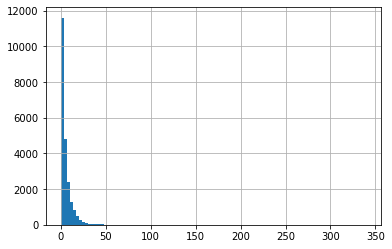

In [923]:
df.ENGAGEMENT.hist(bins=100)

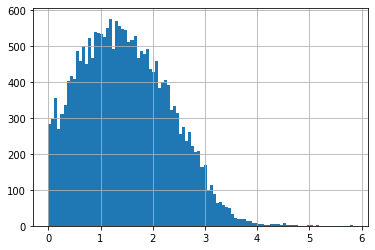

In [924]:
log_ENGAGEMENT = np.log1p(df.ENGAGEMENT)
log_ENGAGEMENT.hist(bins=100)

In [925]:
df['log_ENGAGEMENT'] = log_ENGAGEMENT

In [926]:
print(f'data len Before = {len(df)}')
df = df[df['LIKES'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


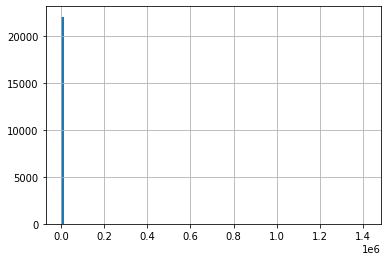

In [927]:
df.LIKES.hist(bins=100)

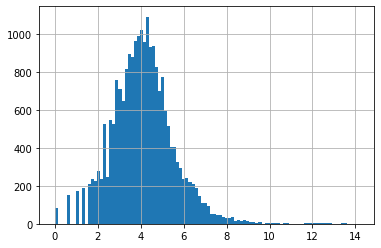

In [928]:
log_LIKES = np.log1p(df.LIKES)
log_LIKES.hist(bins=100)

In [929]:
df['log_LIKES'] = log_LIKES

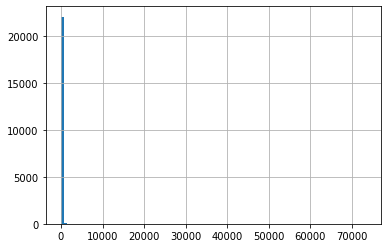

In [930]:
df.COMMENTS.hist(bins=100)

In [931]:
print(f'data len Before = {len(df)}')
df = df[df['COMMENTS'].notna()]
print(f'data len After  = {len(df)}')

data len Before = 22123
data len After  = 22123


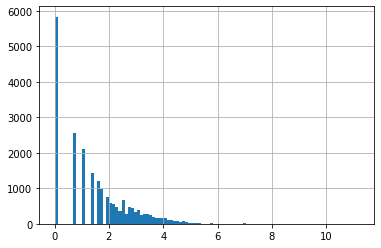

In [932]:
log_COMMENTS = np.log1p(df.COMMENTS)
log_COMMENTS.hist(bins=100)

In [933]:
df['log_COMMENTS'] = log_COMMENTS

##Feature Engeering - Unstack IMAGE_LABELS, 

Eladk 7-Oct-2021

In [934]:
df['IMAGE_LABELS'].unique()

array(['Clothing, Apparel, Text, Money, Collage, Advertisement, Poster',
       'Clothing, Apparel, Person, Human, Female, Swimwear, Footwear, Woman, Bikini, Shoe, Skin, Pants, Flooring, Girl',
       'Clothing, Apparel, Person, Human, Sunglasses, Accessories, Accessory, Face, Scarf, Portrait, Photography, Photo, Glasses, People, Selfie, Female, Coat, Smile',
       ...,
       'Coin, Money, Gold, Flyer, Advertisement, Paper, Poster, Brochure',
       'Nature, Outdoors, Sky, Azure Sky, Horizon, Ice',
       'Face, Person, Human, Female, Plant, Tree, Clothing, Apparel, Woman, Portrait, Photography, Photo, Girl, Palm Tree, Arecaceae, Smile, Selfie, Glasses, Accessories, Accessory, Laughing'],
      dtype=object)

In [935]:
df['CAPTION_INTEREST'].unique()

array(['education', nan, 'entertainment', 'desserts_baking',
       'dating_and_relationships', 'arts_entertainment', 'business',
       'gaming', 'travel', 'news', 'music', 'politics', 'pets',
       'food_drink', 'parenting', 'style_fashion', 'humor', 'sports',
       'accessories', 'technology_computing', 'health', 'home_garden',
       'weddings', 'books_literature', 'legal', 'movies', 'fitness',
       'chef', 'events', 'baking_cooking', 'comic_books',
       'cars_motorcycles', 'hobbies_interests', 'podcasts',
       'green_living', 'barbecues_grilling', 'finance'], dtype=object)

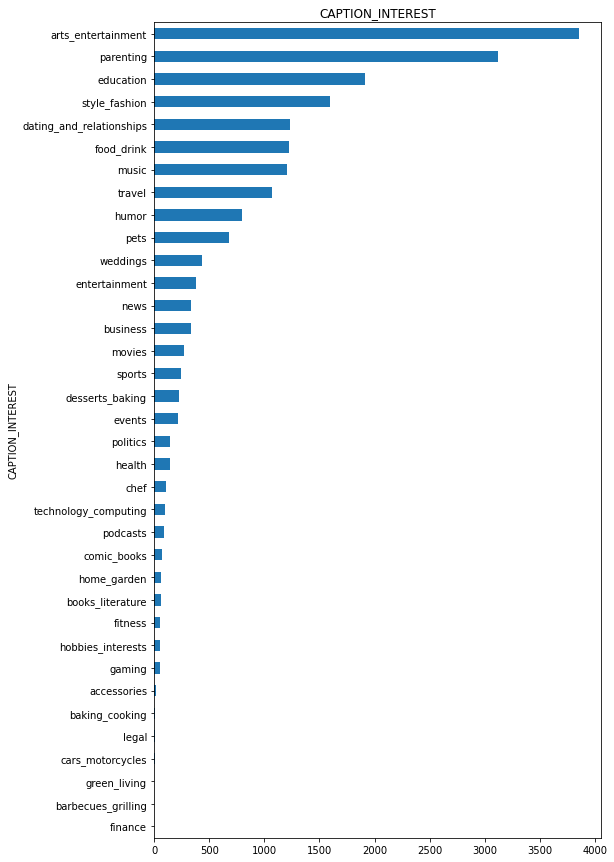

In [936]:
IMAGE_LABELS = df.groupby('CAPTION_INTEREST').size().sort_values()
IMAGE_LABELS.plot.barh(figsize=(8, 15), fontsize=10, title='CAPTION_INTEREST')

Ealdk Oct-5 this execution taks 19 minutes, so i remarked it

In [937]:
# IMAGE_LABELS = df.groupby('IMAGE_LABELS').size().sort_values()
# IMAGE_LABELS.plot.barh(figsize=(8, 15), fontsize=10, title='IMAGE_LABELS')

## Sigma cleaning

In [938]:
# # we lose the most viral posts and most unviral posts
# for col in df.columns:
#     if df[col].dtype == 'float64':
#         std = df[col].std()
#         ave = df[col].mean()
#         df = df.loc[df[col].between\
#                                (ave - (sigma * std), ave + (sigma * std))] 
#         print(f'Processing {col:10} --> {df.shape[0]:5} entities entries remain')

In [939]:
df.describe()

,USERID,FOLLOWER,POST_ID,LIKES,COMMENTS,ENGAGEMENT,TIME,VIDEO_VIEW_COUNT,log_ENGAGEMENT,log_LIKES,log_COMMENTS
count,2.212300e+04,2.212300e+04,2.212300e+04,2.212300e+04,22123.000000,22123.000000,2.212300e+04,4.093000e+03,22123.000000,22123.000000,22123.000000
mean,1.294732e+10,5.353148e+04,2.560923e+18,1.012033e+03,29.686932,5.444202,1.619499e+09,1.448958e+04,1.481362,4.117498,1.515258
std,1.635346e+10,1.011282e+06,1.702821e+17,2.267501e+04,706.415323,7.577142,2.029269e+07,2.316489e+05,0.839813,1.445193,1.335125
min,3.142160e+05,5.000000e+02,6.216878e+17,0.000000e+00,0.000000,0.000000,1.388331e+09,0.000000e+00,0.000000,0.000000,0.000000
25%,5.652381e+08,9.180000e+02,2.560000e+18,2.300000e+01,0.000000,1.270000,1.619573e+09,9.400000e+01,0.819780,3.178054,0.000000
50%,4.459829e+09,1.616000e+03,2.610000e+18,5.700000e+01,3.000000,3.140000,1.624838e+09,2.350000e+02,1.420696,4.060443,1.386294
75%,2.290415e+10,4.140000e+03,2.650000e+18,1.360000e+02,10.000000,6.960000,1.630711e+09,7.290000e+02,2.074429,4.919981,2.397895
max,4.944817e+10,3.636130e+07,2.670000e+18,1.409732e+06,73188.000000,338.740000,1.632341e+09,9.785071e+06,5.828181,14.158911,11.200800


How Many NaN values are ther in the datast?

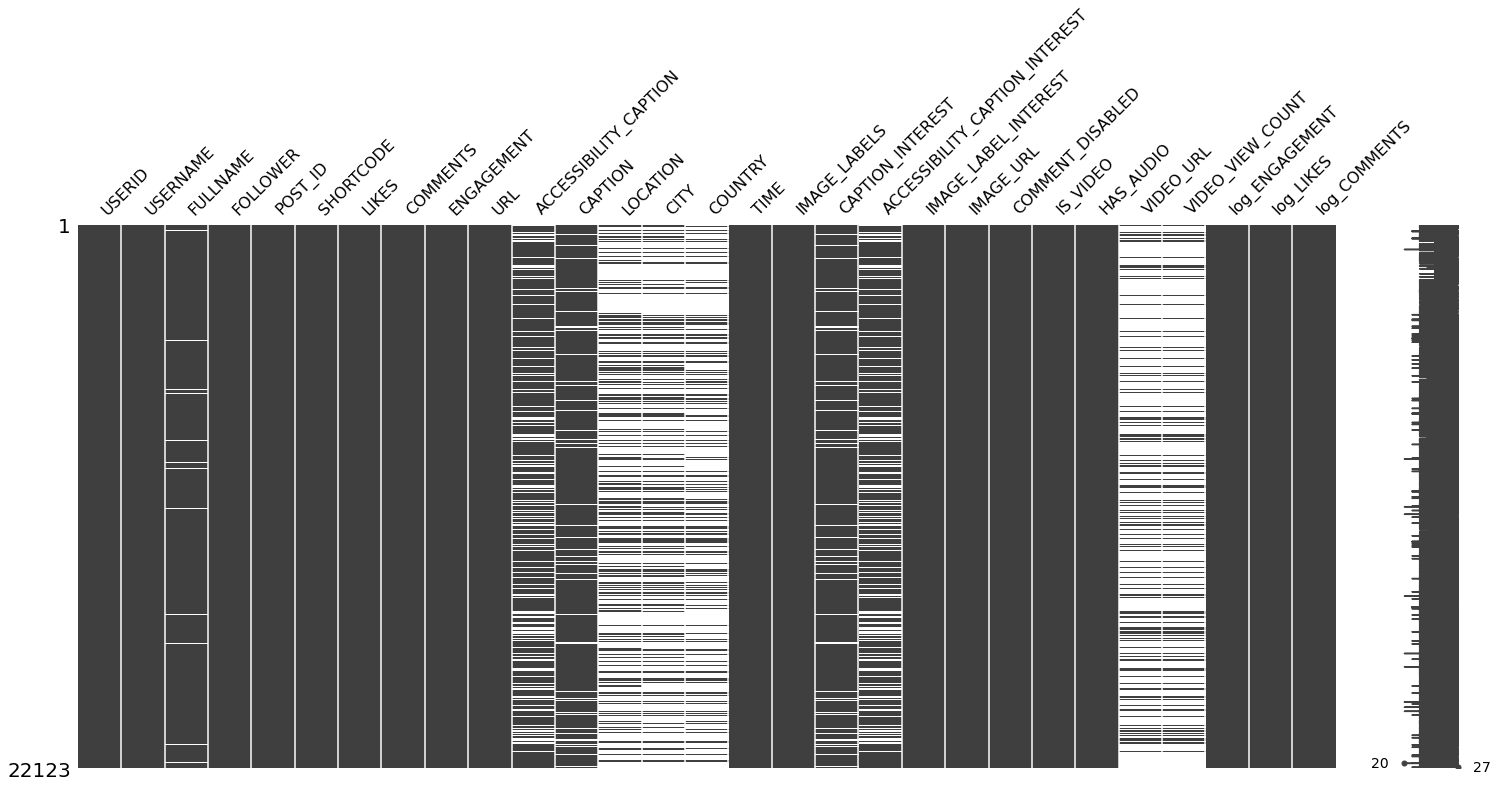

In [940]:
msno.matrix(df)

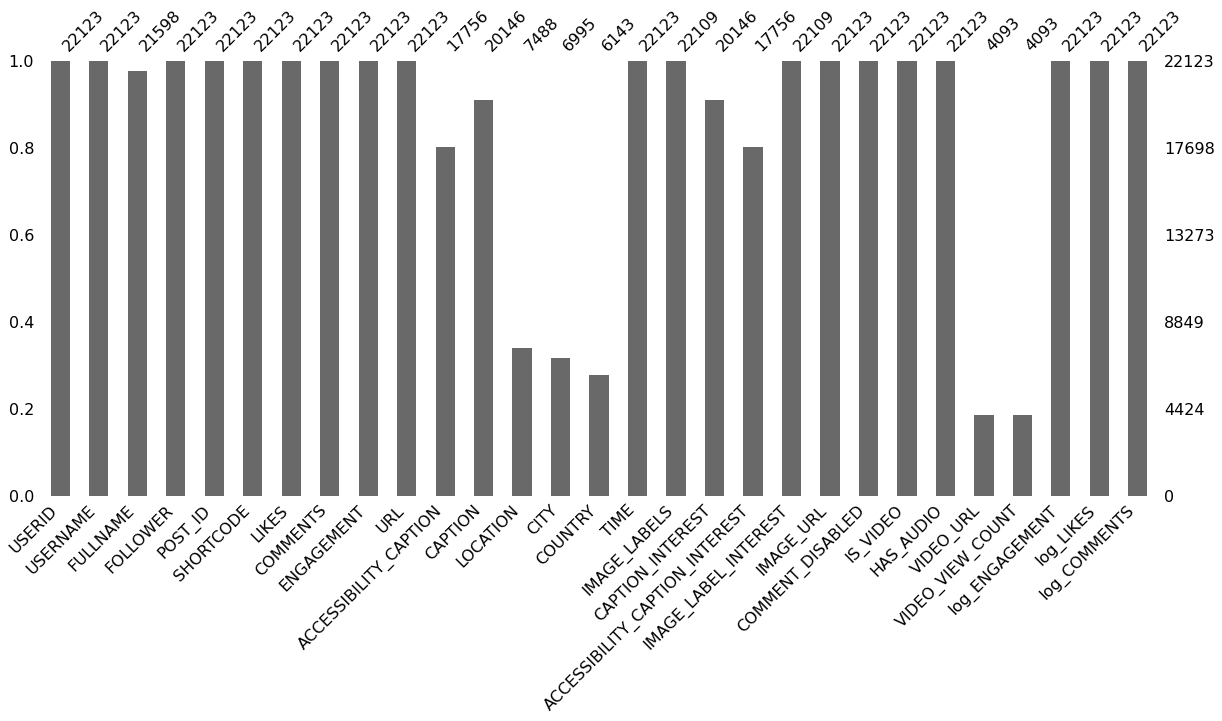

In [941]:
msno.bar(df, figsize=(20, 8))

Conert unix time to separate Date and Time columns

In [942]:
df['DATETIME'] = pd.to_datetime(df['TIME'],unit='s')

In [943]:
df['YEAR'] = pd.DatetimeIndex(df['DATETIME']).year
df['MONTH'] = pd.DatetimeIndex(df['DATETIME']).month
df['DAY'] = pd.DatetimeIndex(df['DATETIME']).day
df['DAYOFWEEK'] = pd.DatetimeIndex(df['DATETIME']).dayofweek
df['HOUR'] = pd.DatetimeIndex(df['DATETIME']).hour
df['MINUTE'] = pd.DatetimeIndex(df['DATETIME']).minute

## Some Data Visualization (mostly on time)

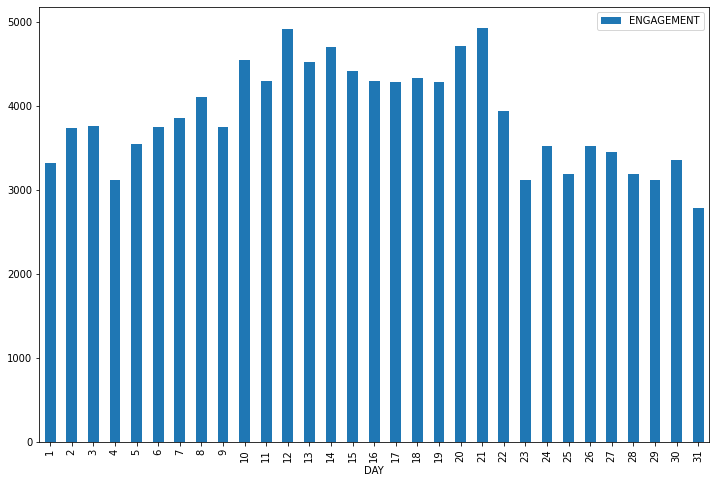

In [944]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

In [945]:
df.columns

Index(['USERID', 'USERNAME', 'FULLNAME', 'FOLLOWER', 'POST_ID', 'SHORTCODE',
       'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL', 'ACCESSIBILITY_CAPTION',
       'CAPTION', 'LOCATION', 'CITY', 'COUNTRY', 'TIME', 'IMAGE_LABELS',
       'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'IMAGE_URL', 'COMMENT_DISABLED', 'IS_VIDEO',
       'HAS_AUDIO', 'VIDEO_URL', 'VIDEO_VIEW_COUNT', 'log_ENGAGEMENT',
       'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR', 'MONTH', 'DAY',
       'DAYOFWEEK', 'HOUR', 'MINUTE'],
      dtype='object')

In [946]:
df.LIKES

1
1918      23
1920     138
1922      46
1929      50
1930     102
        ... 
35893      0
35916      0
36397      2
36489      0
37546      0
Name: LIKES, Length: 22123, dtype: int64

,NUM_OF_LIKES,Average_OF_LIKES,median_OF_LIKES,NUM_OF_LIKES_IN_THOUSANDS
DAYOFWEEK,,,,
0,5250878,1526.861878,59.0,5250.878
1,5030212,1449.211178,54.0,5030.212
2,1468106,439.552695,50.0,1468.106
3,2519352,867.246816,61.0,2519.352
4,3071985,1011.186636,57.0,3071.985
5,1007566,360.359800,62.0,1007.566
6,4041097,1289.437460,61.5,4041.097


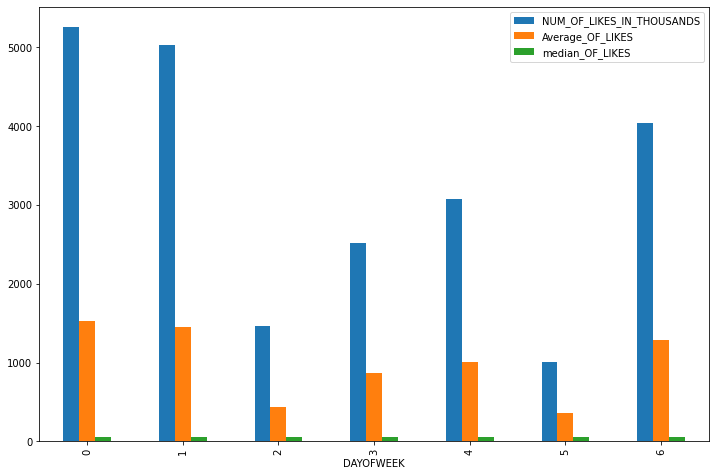

In [947]:
per_DAYOFWEEK = df.groupby('DAYOFWEEK').agg(NUM_OF_LIKES=('LIKES','sum'),
                                            Average_OF_LIKES=('LIKES','mean'),
                                            median_OF_LIKES=('LIKES','median')
                                            )

per_DAYOFWEEK["NUM_OF_LIKES_IN_THOUSANDS"] = per_DAYOFWEEK['NUM_OF_LIKES']/1000
per_DAYOFWEEK.plot(y=["NUM_OF_LIKES_IN_THOUSANDS",
                      "Average_OF_LIKES","median_OF_LIKES"], kind="bar",figsize=(12,8))
per_DAYOFWEEK

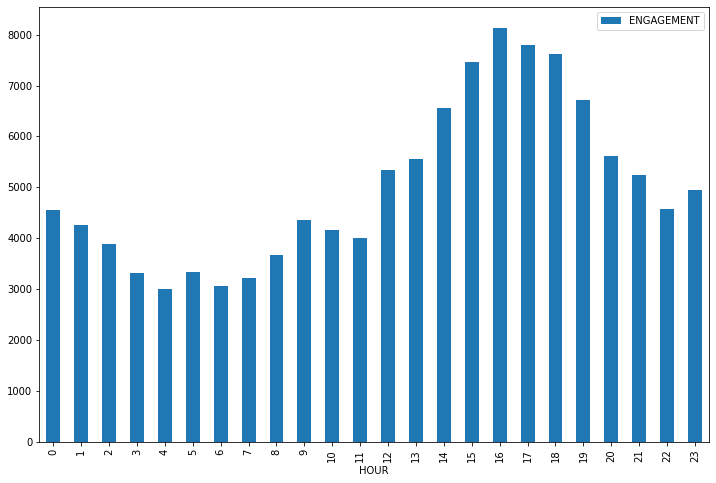

In [948]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

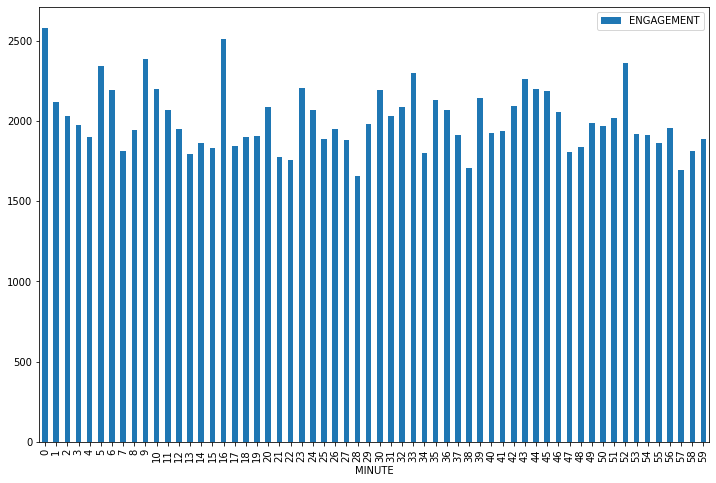

In [949]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["ENGAGEMENT"], kind="bar",figsize=(12,8))

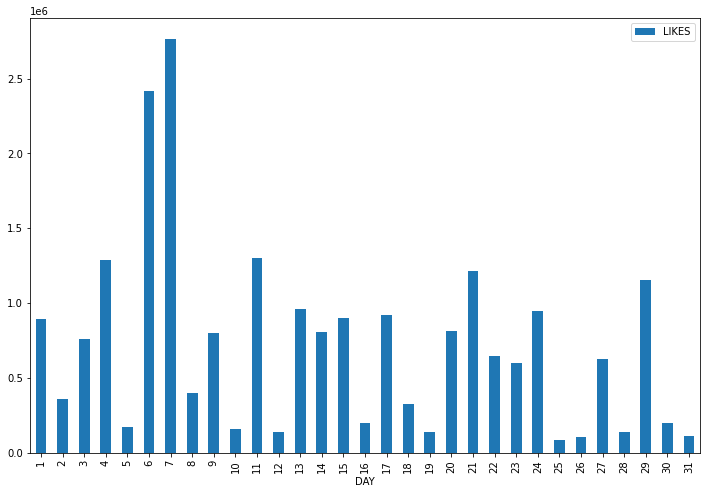

In [950]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["LIKES"], kind="bar",figsize=(12,8))

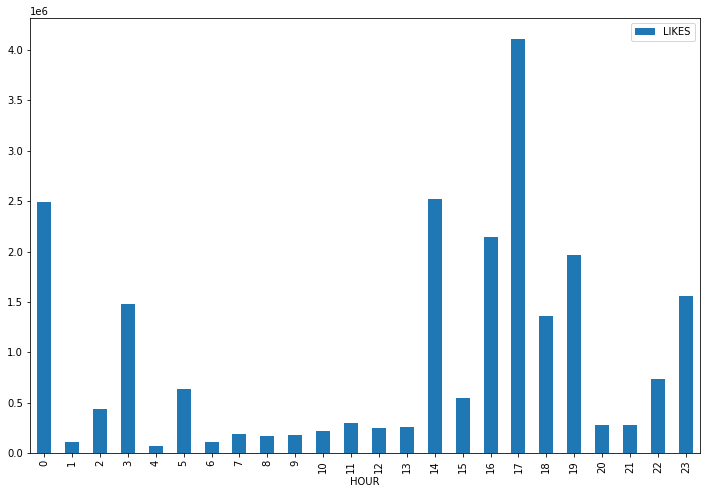

In [951]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["LIKES"], kind="bar",figsize=(12,8))

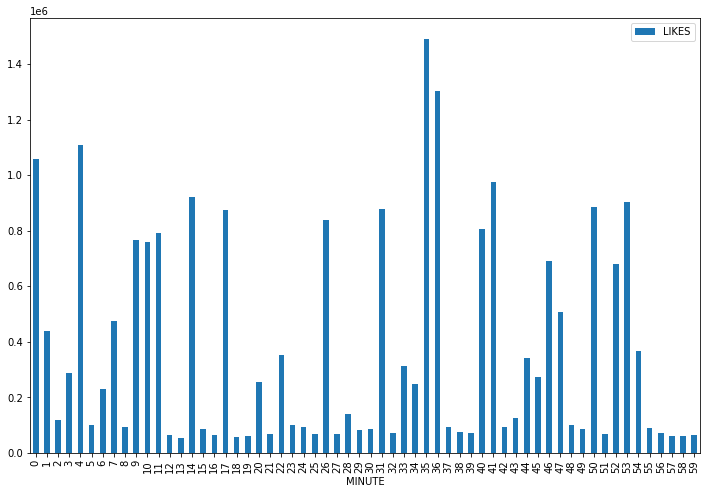

In [952]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["LIKES"], kind="bar",figsize=(12,8))

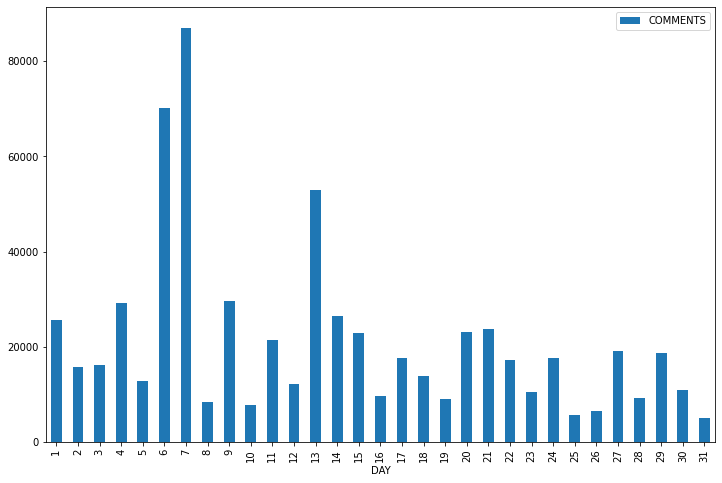

In [953]:
per_DAY = df.groupby(['DAY']).sum()
per_DAY.plot(y=["COMMENTS"], kind="bar",figsize=(12,8))

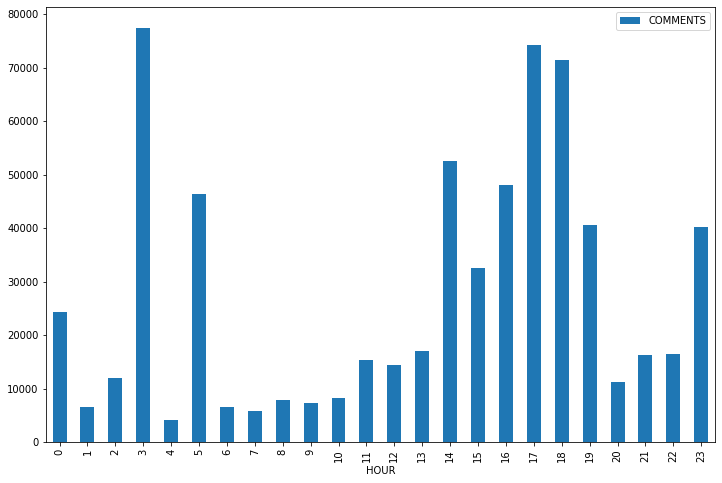

In [954]:
per_HOUR = df.groupby(['HOUR']).sum()
per_HOUR.plot(y=["COMMENTS"], kind="bar",figsize=(12,8))

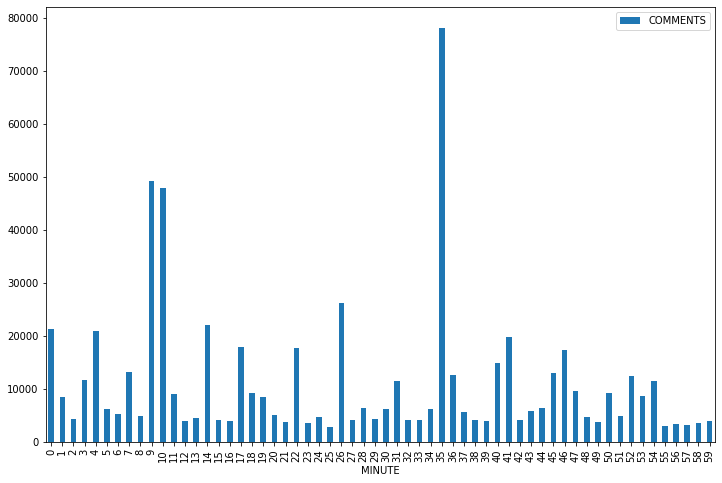

In [955]:
per_MINUTE = df.groupby(['MINUTE']).sum()
per_MINUTE.plot(y=["COMMENTS"], kind="bar",figsize=(12,8))

In [956]:
# per_FULLNAME = df.groupby(['USERNAME']).sum()
# per_FULLNAME.plot(y=["ENGAGEMENT", "LIKES","COMMENTS"], kind="bar",figsize=(12,8))

# plt.title("Total ENGAGEMENT, LIKES, COMMENTS per state",fontsize=15)
# plt.xlabel('FULLNAME',fontsize=12)
# plt.ylabel('ENGAGEMENT, LIKES, COMMENTS',fontsize=12)

Remove column that all values are unique:

In [957]:
for col in df.columns:
    if len(df[col].unique()) == len(df):
        print(col)
        #df.drop(col,inplace=True,axis=1)

IMAGE_URL


In [958]:
df.head()

,USERID,USERNAME,FULLNAME,FOLLOWER,POST_ID,SHORTCODE,LIKES,COMMENTS,ENGAGEMENT,URL,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,TIME,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,IMAGE_URL,COMMENT_DISABLED,IS_VIDEO,HAS_AUDIO,VIDEO_URL,VIDEO_VIEW_COUNT,log_ENGAGEMENT,log_LIKES,log_COMMENTS,DATETIME,YEAR,MONTH,DAY,DAYOFWEEK,HOUR,MINUTE
1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1918,36193140327,elastici_e_passamaneria,Elastici e Passamaneria,1052,2.530601e+18,CMegChUlwm2,23,0,2.19,https://www.instagram.com/p/CMegChUlwm2,"Photo by Elastici e Passamaneria on March 16, 2021.",FFP2 MADE IN ITALY????????#ffp2mask#italianstyle#madeinitaly????????#produzionepropria#produttori#farmacie#farmacieitaliane#parafarmacia#mascherinelavabili#mask#ffp2,NaN,NaN,NaN,1615891163,"Clothing, Apparel, Text, Money, Collage, Advertisement, Poster",education,movies,business,https://instagram.fdok2-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.180.1440.1440a/s640x640/160374486_2823675294516254_158720847037227315_n.jpg?tp=1&_nc_ht=instagram.fdok2-1.fna.fbcdn.net&_nc_cat=102&_nc_ohc=fXOFeWEt3dcAX9moTcA&edm=ABfd0MgBAAAA&ccb=7-4&oh=cc36e9f840bc93314fcc9e76c9e4b8c6&oe=60DA4B27&_nc_sid=7bff83,no,no,no,NaN,NaN,1.160021,3.178054,0.000000,2021-03-16 10:39:23,2021,3,16,1,10,39
1920,36838177086,ilaria._004,????????????????,649,2.356209e+18,CCy784yAY26,138,2,21.57,https://www.instagram.com/p/CCy784yAY26,"Photo by ???????????????? on July 18, 2020. May be an image of 1 person.",mirame????,NaN,NaN,NaN,1595102049,"Clothing, Apparel, Person, Human, Female, Swimwear, Footwear, Woman, Bikini, Shoe, Skin, Pants, Flooring, Girl",education,arts_entertainment,style_fashion,https://instagram.fgua5-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c0.86.1080.1080a/s640x640/111218478_173463267523124_4585802501296990831_n.jpg?tp=1&_nc_ht=instagram.fgua5-1.fna.fbcdn.net&_nc_cat=108&_nc_ohc=3eLtxoYSgkUAX-UqCUh&edm=ABfd0MgBAAAA&ccb=7-4&oh=8ca65c0f03f5315391059b88e4879625&oe=60DAB7D9&_nc_sid=7bff83,no,no,no,NaN,NaN,3.116622,4.934474,1.098612,2020-07-18 19:54:09,2020,7,18,5,19,54
1922,5633363536,amineblc,Mohamed Amine,1103,2.127312e+18,B2Fuq_ylPo_,46,4,4.53,https://www.instagram.com/p/B2Fuq_ylPo_,Photo by Mohamed Amine in Mawazine.,NaN,Mawazine,"Ksar Hellal, Tunisia",Tunisia,1567815333,"Clothing, Apparel, Person, Human, Sunglasses, Accessories, Accessory, Face, Scarf, Portrait, Photography, Photo, Glasses, People, Selfie, Female, Coat, Smile",NaN,news,style_fashion,https://instagram.fjdf6-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/c180.0.1079.1079a/s640x640/68822328_1329001810597157_525683053977317248_n.jpg?tp=1&_nc_ht=instagram.fjdf6-1.fna.fbcdn.net&_nc_cat=105&_nc_ohc=Oab_ik_P9acAX_VBh4i&edm=ABfd0MgBAAAA&ccb=7-4&oh=310007350b72a7c0ca933d072e7fe557&oe=60DAC5ED&_nc_sid=7bff83,no,no,no,NaN,NaN,1.710188,3.850148,1.609438,2019-09-07 00:15:33,2019,9,7,5,0,15
1929,555815104,vittoria_caron,V i t t o r i a C a r o n,1076,2.448009e+18,CH5E6XPDO_y,50,2,4.83,https://www.instagram.com/p/CH5E6XPDO_y,"Photo by V i t t o r i a C a r o n in Palermo, Italy with @federico_alberti_. May be an image of 2 people, outerwear and monument.","Throwback a quando eravamo felici e abbronzati. Ma soprattutto, fuori di casa. #lockdown #tb","Palermo, Italy","Palermo, Province of Palermo, Italy",Italy,1606045492,"Person, Human, Clothing, Apparel, Sitting, Shorts, Architecture, Building, Female, Couch, Furniture, Shoe, Footwear, Pillar, Column, Flagstone, Woman",entertainment,music,style_fashion,https://instagram.fmad10-1.fna.fbcdn.net/v/t51.2885-15/sh0.08/e35/s640x640/125948565_1705795609581805_7496045465512730599_n.jpg?tp=1&_nc_ht=instagram.fmad10-1.fna.fbcdn.net&_nc_cat=101&_nc_ohc=Ch4eZDGY24oAX-YFqQL&edm=ABfd0MgBAAAA&ccb=7-4&oh=5aad3be023aaf33d776f03322fcefe17&oe=60D9F693&_nc_sid=7bff83,no,no,no,NaN,NaN,1.763017,3.931826,1.098612,2020-11-22 11:44:52,2020,11,22,6,11,44
1930,2727935277,mr_artworker_,Shivam Rathore⊂(◉‿◉)つ,1319,2.580835e+18,CPQ93T1FJfN,102,8,8.34,https://www.instagram.com/p/CP

In [959]:
df.URL.head()
# SHORTCODE
# URL
# IMAGE_URL
# VIDEO_URL # Not working

1
1918    https://www.instagram.com/p/CMegChUlwm2
1920    https://www.instagram.com/p/CCy784yAY26
1922    https://www.instagram.com/p/B2Fuq_ylPo_
1929    https://www.instagram.com/p/CH5E6XPDO_y
1930    https://www.instagram.com/p/CPQ93T1FJfN
Name: URL, dtype: object

## creating new columns for featur engeneering base on the columns of CAPTION ,ACCESSIBILITY_CAPTION, IMAGE_LABELS :

new columns for featur engeneering for 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS':
*   Number of Hash # in 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS',
*   Number of AT @ in CAPTION
*   Number of question mark? in CAPTION
*   Number of , in CAPTION
*   Number of Words in CAPTION

7-Oct

In [960]:
#count number of !
#df['exc'] = df['line'].map(lambda x: x.count("!"))

In [961]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)

In [962]:
#Number of Words in CAPTION:
#d['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df[df.index == 2728].CAPTION.tolist()]
#d['words'] = [len(x.split()) for x in d['CAPTION'].tolist()]
#df['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df['CAPTION'].tolist()]

Sampleing:

In [963]:
num_of_samples = 5
list_of_sample_index = list((df.URL.sample(num_of_samples).index.values))
print('indesc sample are: ', list_of_sample_index)
print(df.loc[list_of_sample_index]['URL'])
df.loc[list_of_sample_index][['LIKES','CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS','CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST','IMAGE_LABEL_INTEREST'
,'FOLLOWER','LOCATION'
]]

indesc sample are:  [3587, 6499, 10324, 26369, 37290]
1
3587     https://www.instagram.com/p/CPrOVJtpzkt
6499     https://www.instagram.com/p/COurVu7ldlT
10324    https://www.instagram.com/p/CG8I0MQFk5u
26369    https://www.instagram.com/p/CSy12S4Awi5
37290    https://www.instagram.com/p/CPtN-qtjFGb
Name: URL, dtype: object


,LIKES,CAPTION,ACCESSIBILITY_CAPTION,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,FOLLOWER,LOCATION
1,,,,,,,,,
3587,421,being “overdressed” is a myth made up by people who don’t want u to be sexy????,"Photo by shann jacqueline ☁️ twenty one on June 03, 2021. May be an image of 1 person.","Person, Human, Face, Blonde, Teen, Kid, Child, Female, Woman, Girl, Necklace, Accessories, Jewelry, Accessory, Pendant, Hair, Home Decor",pets,pets,style_fashion,7923,"Bristol, United Kingdom"
6499,67,Tandoori soya chap with pudina Chutney ❤️\n\nMade by my Bhabhi ????\n\nBenefit of having a foodie family ????\n\nFollow @Foodiegirl_intown\nFollow @Foodiegirl_intown\nFollow @Foodiegirl_intown\n\n#soyachaap #chaap #foodphotography #foodie #foodblogger #foodporn #foodstagram #indianfood #food #malaichaap #delhifood #streetfood #delhistreetfood #delhi #yummy #instafood #foodiegirl_intown #foodiesofinstagram #chaaptikka #tandoori #delicious #soya #tasty #tandoorichaap #delhifoodblogger #foodgasm #homemadefoo,"Photo by Foodiegirl Intown in Surat, Gujarat with @payalchanda_1291, @sucheta.maitra, @chef_arielle23, @chef_afroj, @patnaik.susmita, @chef.prabhakar, @chef_mike_h, @foodchoir_2020, @chefali1027, @food_snaps_999, @food.isbae66, @the.little.apron, @food_is_bae143, @foodie_mumma_baby, @foodchasak, @food_storieswithtrisha, @kyakhaaega, and @veggie_singh.","Dish, Meal, Food, Platter, Plant, Culinary, Animal",food_drink,events,food_drink,4277,"Surat, Gujarat"
10324,105,NaN,"Photo by Giulia Porta on October 29, 2020. May be an image of 1 person.","Clothing, Apparel, Dress, Face, Person, Human, Hat, Female, Blonde, Woman, Girl, Kid, Teen, Child, Yard, Outdoors, Nature, Tree, Plant, Street, Road, City, Urban, Building, Town, Portrait, Photography, Photo, Countryside, Shelter, Rural, Smile, Brick, Pants, Grass, Lady, Housing, Costume, Head, Fashion, Coat, Ground",NaN,travel,style_fashion,669,NaN
26369,95,Avance Capítulo 77 De #lareinadelflow2,NaN,"Eclipse, Astronomy",entertainment,NaN,technology_computing,1353,NaN
37290,44,NaN,"Photo by @mahtab_darb_novin on June 04, 2021. May be an image of indoor.","Gas Pump, Machine, Pump, Safe, Door",NaN,arts_entertainment,business,983,NaN


## Remove unneccessary columns from Dataframe

In [964]:
df.drop(['POST_ID','VIDEO_URL','SHORTCODE','IMAGE_URL','USERID','FULLNAME','USERNAME',
         'USERID','TIME',#'URL',
         'VIDEO_VIEW_COUNT'],inplace=True,axis=1)

After talking with Royi on 1-Oct: 

In [965]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22123 entries, 1918 to 37546
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   FOLLOWER                        22123 non-null  int64         
 1   LIKES                           22123 non-null  int64         
 2   COMMENTS                        22123 non-null  int64         
 3   ENGAGEMENT                      22123 non-null  float64       
 4   URL                             22123 non-null  object        
 5   ACCESSIBILITY_CAPTION           17756 non-null  object        
 6   CAPTION                         20146 non-null  object        
 7   LOCATION                        7488 non-null   object        
 8   CITY                            6995 non-null   object        
 9   COUNTRY                         6143 non-null   object        
 10  IMAGE_LABELS                    22109 non-null  object        
 11 

Convert columns type to characters :

In [966]:
df['COMMENT_DISABLED'].value_counts()

no     21990
yes      133
Name: COMMENT_DISABLED, dtype: int64

In [967]:
df['COMMENT_DISABLED'] = df['COMMENT_DISABLED'].map(dict(yes=1, no=0))

In [968]:
df['IS_VIDEO'] = df['IS_VIDEO'].map(dict(yes=1, no=0))

In [969]:
df['HAS_AUDIO'] = df['HAS_AUDIO'].map(dict(yes=1, no=0))

In [970]:
df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].value_counts()

COMMENT_DISABLED  IS_VIDEO  HAS_AUDIO
0                 0         0            17929
                  1         1             3787
                            0              274
1                 0         0              101
                  1         1               26
                            0                6
dtype: int64

In [971]:
pd.unique(df[['COMMENT_DISABLED','IS_VIDEO','HAS_AUDIO']].values.ravel('K'))

array([0, 1])

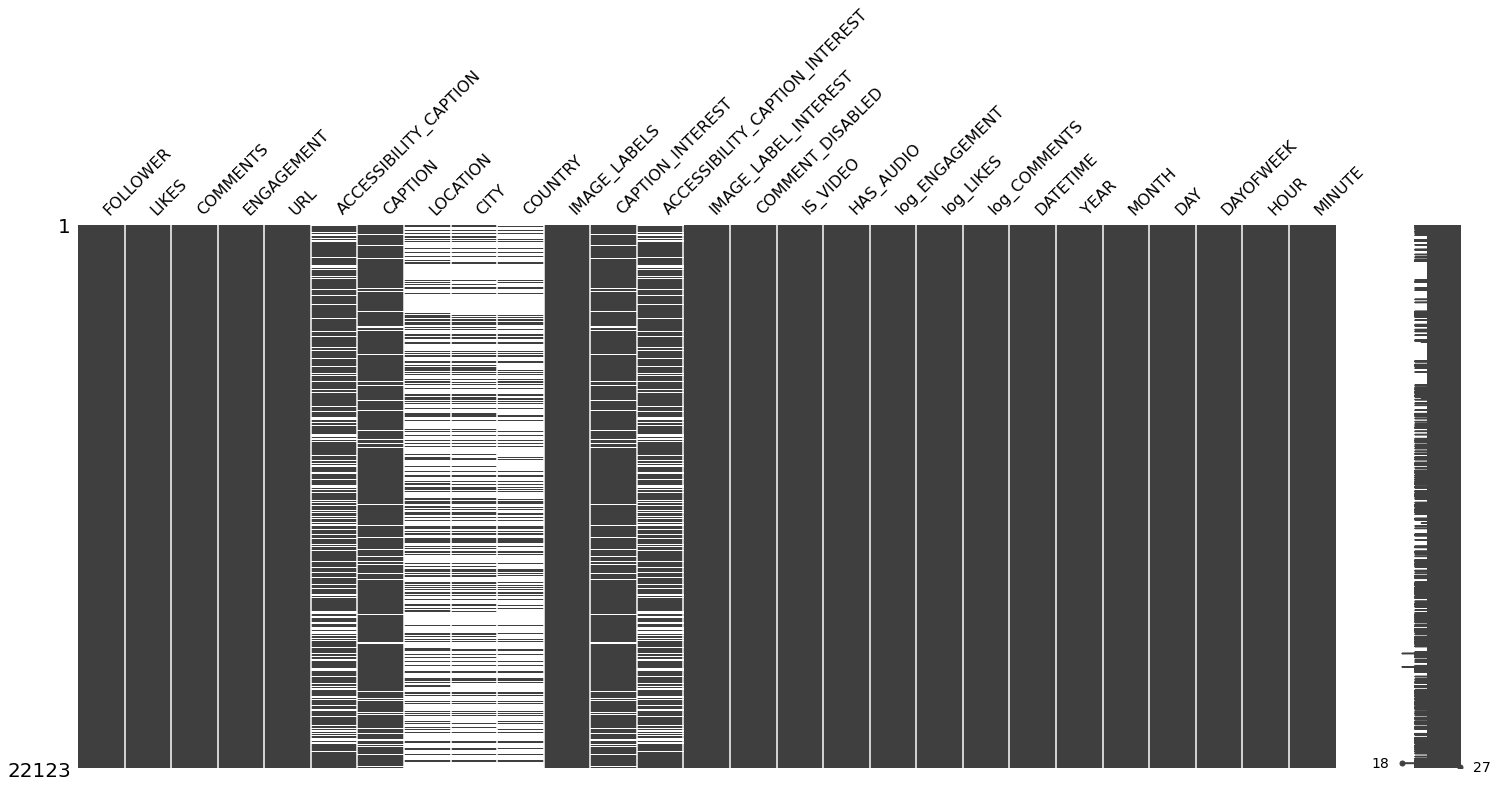

In [972]:
msno.matrix(df)

In [973]:
df.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL',
       'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'IMAGE_LABELS', 'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE'],
      dtype='object')

Raname the index

In [974]:
df = df.rename_axis('LINE_NUM_INDEX')

Note by Eladk: we can fill location values by using a merdiction model base in the influancer and the time for the post. <BR> 
For Now, I'll just fill the columns with NULL

Replace all cases where VIDEO_VIEW_COUNT == Nan with 0. <BR> for double check i verified it with is_video column

Eladk note 8-Sep-2021: I still need to handle missing values in column:


*   FULLNAME
*   ACCESSIBILITY_CAPTION - specify full name, time, location, video or picture and tag
*   CAPTION - the text on this post (by the post uploader
*   LOCATION, CITY, COUNTRY - location
*   CAPTION_INTEREST -
*   ACCESSIBILITY_CAPTION_INTEREST


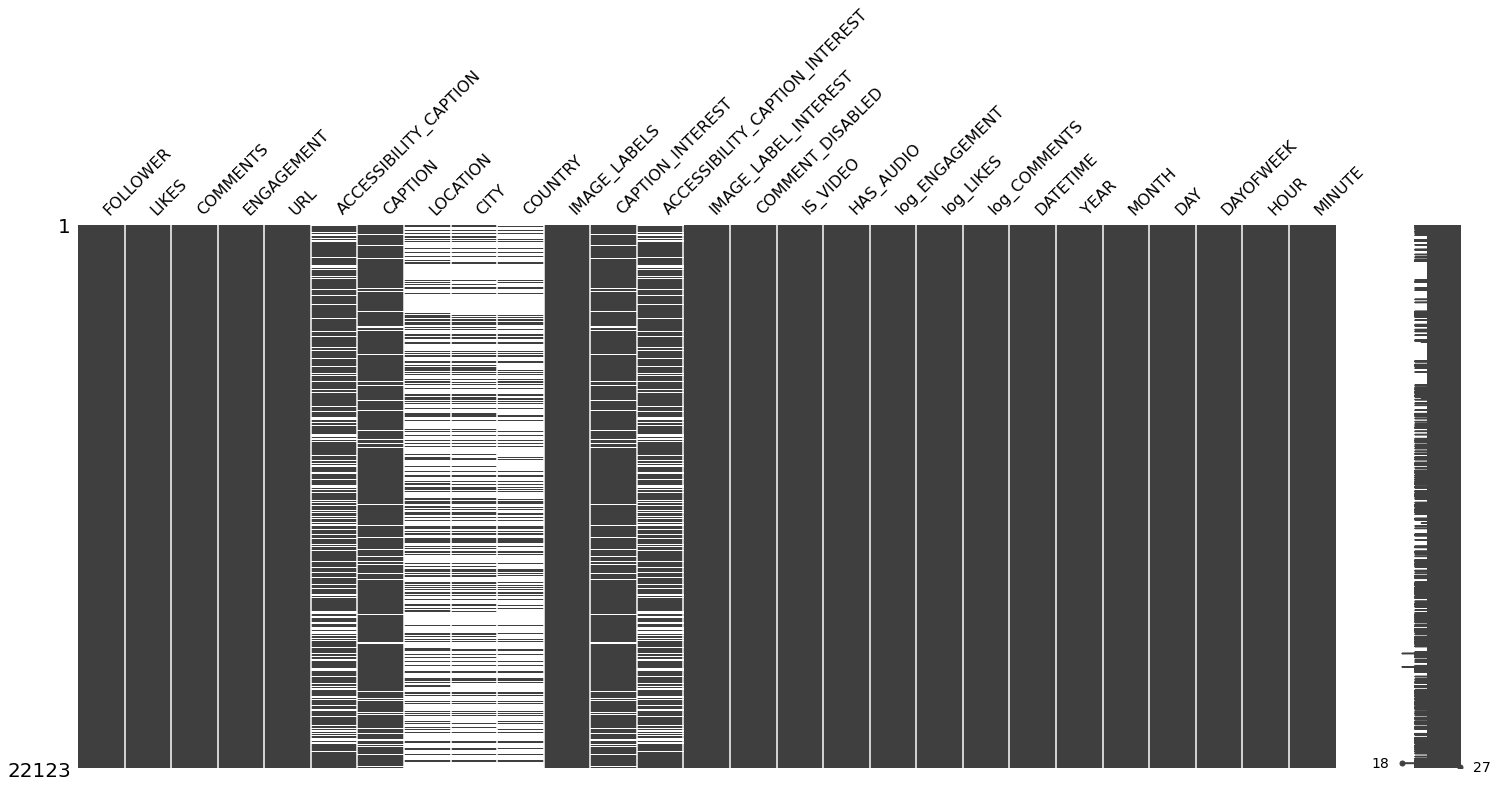

In [975]:
msno.matrix(df)

In [976]:
df.CAPTION.value_counts().sort_values(ascending=False)

????                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    179
????????                                                                                                                                                                                                                                                                                                                                                                                                    

selecting a subset of the data:

In [977]:
df[['ACCESSIBILITY_CAPTION','CAPTION','LOCATION', 'CITY', 'COUNTRY'\
    ,'CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(5)

,ACCESSIBILITY_CAPTION,CAPTION,LOCATION,CITY,COUNTRY,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,,,,,,
1918,"Photo by Elastici e Passamaneria on March 16, 2021.",FFP2 MADE IN ITALY????????#ffp2mask#italianstyle#madeinitaly????????#produzionepropria#produttori#farmacie#farmacieitaliane#parafarmacia#mascherinelavabili#mask#ffp2,NaN,NaN,NaN,education,movies
1920,"Photo by ???????????????? on July 18, 2020. May be an image of 1 person.",mirame????,NaN,NaN,NaN,education,arts_entertainment
1922,Photo by Mohamed Amine in Mawazine.,NaN,Mawazine,"Ksar Hellal, Tunisia",Tunisia,NaN,news
1929,"Photo by V i t t o r i a C a r o n in Palermo, Italy with @federico_alberti_. May be an image of 2 people, outerwear and monument.","Throwback a quando eravamo felici e abbronzati. Ma soprattutto, fuori di casa. #lockdown #tb","Palermo, Italy","Palermo, Province of Palermo, Italy",Italy,entertainment,music
1930,NaN,????,NaN,NaN,NaN,education,NaN


Increase the length to a column so that we'll see all the text in a cell

In [978]:
pd.options.display.max_colwidth = 1000
df.ACCESSIBILITY_CAPTION.head(5)

LINE_NUM_INDEX
1918                                                                                     Photo by Elastici e Passamaneria on March 16, 2021.
1920                                                                Photo by ???????????????? on July 18, 2020. May be an image of 1 person.
1922                                                                                                     Photo by Mohamed Amine in Mawazine.
1929    Photo by V i t t o r i a   C a r o n in Palermo, Italy with @federico_alberti_. May be an image of 2 people, outerwear and monument.
1930                                                                                                                                     NaN
Name: ACCESSIBILITY_CAPTION, dtype: object

Selecting 1 row by index (specific column only)

In [979]:
#df[df.index == 1929][['URL','ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 
df[df.index == 1929][['ACCESSIBILITY_CAPTION','DATETIME','LOCATION']] # name, 

,ACCESSIBILITY_CAPTION,DATETIME,LOCATION
LINE_NUM_INDEX,,,
1929,"Photo by V i t t o r i a C a r o n in Palermo, Italy with @federico_alberti_. May be an image of 2 people, outerwear and monument.",2020-11-22 11:44:52,"Palermo, Italy"


In [980]:
df.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'URL',
       'ACCESSIBILITY_CAPTION', 'CAPTION', 'LOCATION', 'CITY', 'COUNTRY',
       'IMAGE_LABELS', 'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE'],
      dtype='object')

In [981]:
df[['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']].head(20)

,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,
1918,education,movies
1920,education,arts_entertainment
1922,NaN,news
1929,entertainment,music
1930,education,NaN
1932,desserts_baking,travel
1934,desserts_baking,NaN
1935,dating_and_relationships,NaN
1936,arts_entertainment,movies


In [982]:
#df[df.index == 1932][['URL','CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name, 
df[df.index == 1932][['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']] # name,

,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST
LINE_NUM_INDEX,,
1932,desserts_baking,travel


there are 308 combination as CAPTION_INTEREST and ACCESSIBILITY_CAPTION_INTEREST

In [983]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,counts
0,arts_entertainment,arts_entertainment,1228
1,parenting,arts_entertainment,1012
2,education,arts_entertainment,785
3,arts_entertainment,travel,573
4,parenting,travel,531
5,style_fashion,arts_entertainment,483
6,arts_entertainment,style_fashion,421
7,dating_and_relationships,arts_entertainment,396
8,style_fashion,style_fashion,379
9,music,arts_entertainment,354


there are 35 unique CAPTION_INTEREST


In [984]:
df.groupby(['CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

,CAPTION_INTEREST,counts
0,arts_entertainment,3856
1,parenting,3120
2,education,1917
3,style_fashion,1599
4,dating_and_relationships,1233
5,food_drink,1220
6,music,1208
7,travel,1073
8,humor,800
9,pets,676


there are 26 unique ACCESSIBILITY_CAPTION_INTEREST


In [985]:
df.groupby(['ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(30)

,ACCESSIBILITY_CAPTION_INTEREST,counts
0,arts_entertainment,7427
1,travel,3111
2,style_fashion,1922
3,food_drink,1088
4,parenting,765
5,events,714
6,music,649
7,movies,417
8,pets,343
9,books_literature,145


Eladk 1-Oct , creat new column the state if CAPTION_INTEREST == ACCESSIBILITY_CAPTION_INTEREST

In [986]:
df.groupby(['CAPTION_INTEREST','ACCESSIBILITY_CAPTION_INTEREST']).size().sort_values(ascending=False).reset_index(name='counts').head(50)

,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,counts
0,arts_entertainment,arts_entertainment,1228
1,parenting,arts_entertainment,1012
2,education,arts_entertainment,785
3,arts_entertainment,travel,573
4,parenting,travel,531
5,style_fashion,arts_entertainment,483
6,arts_entertainment,style_fashion,421
7,dating_and_relationships,arts_entertainment,396
8,style_fashion,style_fashion,379
9,music,arts_entertainment,354


## ## Handle NaN valus 

For Now (Eladk 2021-Sep-11) I'll fill every NaN with Null

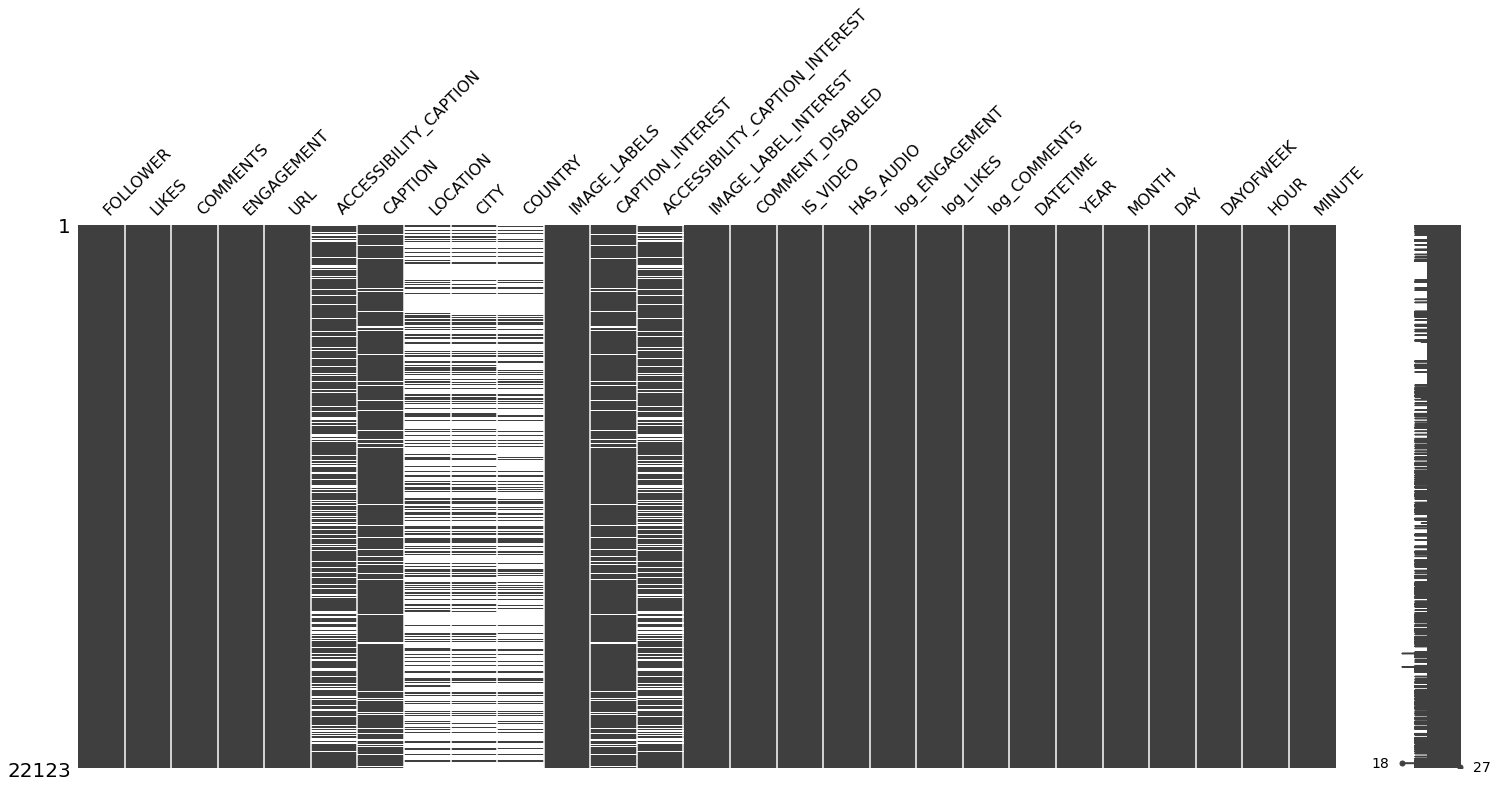

In [987]:
msno.matrix(df)

In [988]:
#https://datatofish.com/rows-with-nan-pandas-dataframe/
#len(df[df['FULLNAME'].isna()]) # 126 #849
#df[df['FULLNAME'].isnull()]
#df[df.isna().any(axis=1)] # len = 4020
#df[df.isnull().any(axis=1)]

In [989]:
for col in df.columns:
    if len(df[df[col].isnull()]) > 0:
      df[col] = df[col].fillna('Null')
      print(col)

ACCESSIBILITY_CAPTION
CAPTION
LOCATION
CITY
COUNTRY
IMAGE_LABELS
CAPTION_INTEREST
ACCESSIBILITY_CAPTION_INTEREST
IMAGE_LABEL_INTEREST


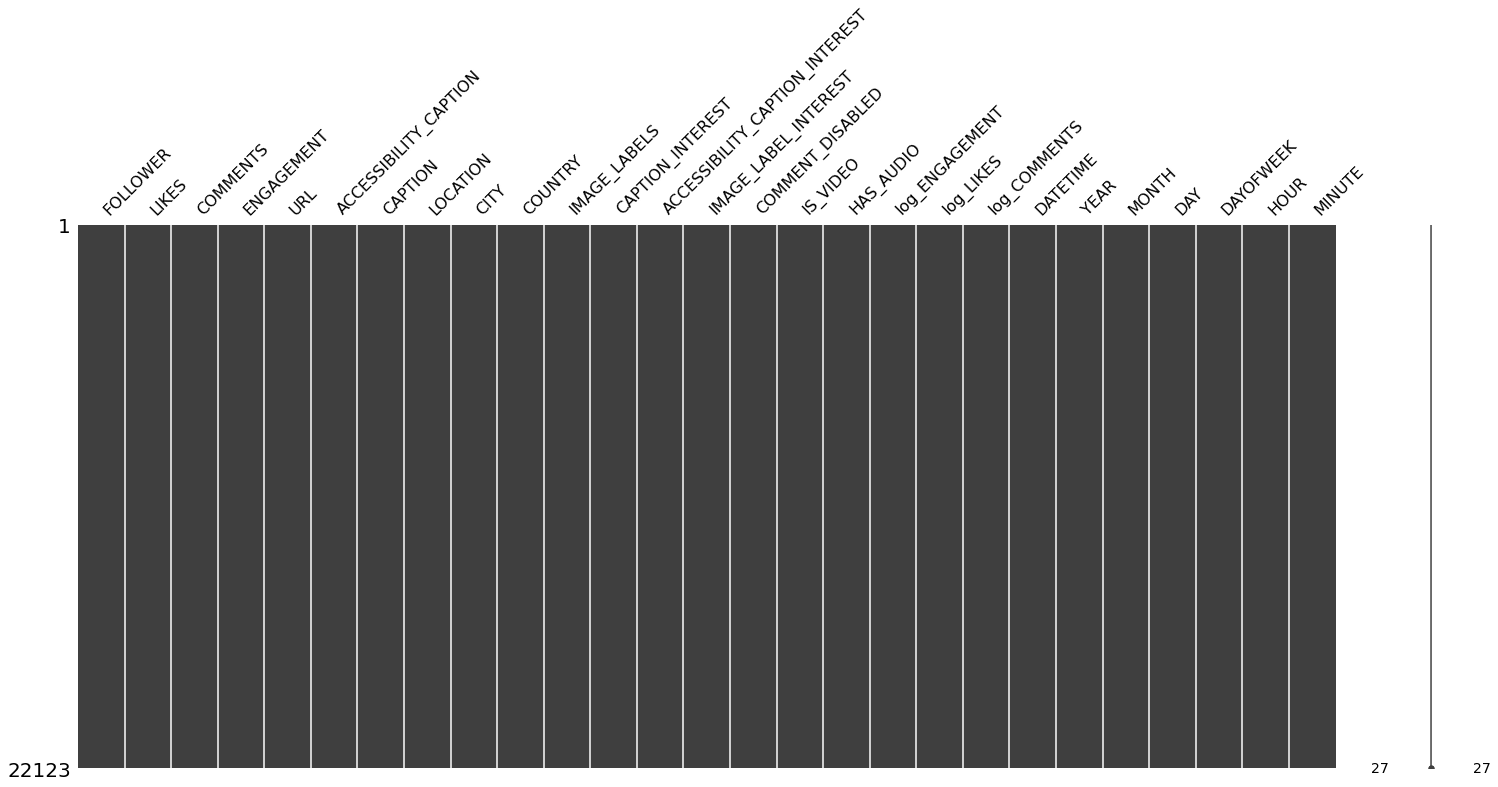

In [990]:
msno.matrix(df)

## creating new columns for featur engeneering base on the columns of CAPTION ,ACCESSIBILITY_CAPTION, IMAGE_LABELS :

new columns for featur engeneering for 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS':
*   Number of Hash # in 'CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS',
*   Number of AT @ in CAPTION
*   Number of question mark? in CAPTION
*   Number of , in CAPTION
*   Number of Words in CAPTION

the source for the code is from: https://towardsdatascience.com/9-functions-that-make-natural-language-pre-processing-a-piece-of-cake-8b885c151955 <BR>
7-Oct

In [991]:
#count number of !
#df['exc'] = df['line'].map(lambda x: x.count("!"))

In [992]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)
d

,CAPTION
LINE_NUM_INDEX,
2728,Happy 63rd Independence Day Malaysia.!Wish all of Malaysian regardless of races and religion a prosperity and abundance of joy in making our country one of the great. ????????????????????\n.\n.\n.\n#Malaysia #independence #63rd #ohmalaysiaku #onenation #malaysiaprihatin #staysafe #newnormal #rb


In [993]:
'Number_of_expamation_mark_in_CAPTION'.upper()

'NUMBER_OF_EXPAMATION_MARK_IN_CAPTION'

In [994]:
#Count the most repeated words example:
pd.DataFrame(Counter('elad elad katz elad katz'.split()).most_common(2000), columns=['word', 'frequency'])

,word,frequency
0,elad,3
1,katz,2


In [995]:
#Count the most repeated words
#from collections import Counter
#pd.DataFrame(Counter(d[['CAPTION']].split()).most_common(200), columns=['word', 'frequency'])

In [996]:
'exclamation'.upper()

'EXCLAMATION'

In [997]:
#Number of Words in CAPTION:
df['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df['CAPTION'].tolist()]

In [998]:
df['NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("!"))

In [999]:
df['NUMBER_OF_QUESTION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("?"))

In [1000]:
df['NUMBER_OF_HASH_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("#"))

In [1001]:
df['NUMBER_OF_AT_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("@"))

In [1002]:
df['NUMBER_OF_COMMA_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count(","))

New columns for feature engineering cased on Caption:

In [1003]:
df['NUMBER_OF_WORDS_IN_CAPTION'] = [len(x.split()) for x in df['CAPTION'].tolist()]
df['NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("!"))
df['NUMBER_OF_QUESTION_MARK_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("?"))
df['NUMBER_OF_HASH_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("#"))
df['NUMBER_OF_AT_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count("@"))
df['NUMBER_OF_COMMA_IN_CAPTION'] = df['CAPTION'].map(lambda x: x.count(","))

New columns for feature engineering cased on ACCESSIBILITY_CAPTION:

In [1004]:
df['NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN'] = [len(x.split()) for x in df['ACCESSIBILITY_CAPTION'].tolist()]
df['NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("!"))
df['NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("?"))
df['NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("#"))
df['NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count("@"))
df['NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION'] = df['ACCESSIBILITY_CAPTION'].map(lambda x: x.count(","))

In [1005]:
#10. Count emojis
# import emoji
# emojis_df=[]
# for string in df['line']:
#     my_str = str(string)
#     for each in my_str:
#         if each in emoji.UNICODE_EMOJI:
#             emojis_df.append(each)
# freq = dict(Counter(i for sub in emojis_df for i in set(sub))) 
# sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)

View specific line

In [1006]:
d = pd.DataFrame(df[df.index == 2728].CAPTION)

Sampling the row data df:

In [1007]:
num_of_samples = 5
list_of_sample_index = list((df.URL.sample(num_of_samples).index.values))
print('indesc sample are: ', list_of_sample_index)
print(df.loc[list_of_sample_index]['URL'])
df.loc[list_of_sample_index][['LIKES','CAPTION','ACCESSIBILITY_CAPTION','IMAGE_LABELS','CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST','IMAGE_LABEL_INTEREST'
,'FOLLOWER','LOCATION'
,'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION','NUMBER_OF_QUESTION_MARK_IN_CAPTION','NUMBER_OF_HASH_IN_CAPTION','NUMBER_OF_AT_IN_CAPTION','NUMBER_OF_COMMA_IN_CAPTION' # <- new added columns
]]

indesc sample are:  [33206, 17377, 31288, 2714, 21507]
LINE_NUM_INDEX
33206    https://www.instagram.com/p/CKlMI57pTbl
17377    https://www.instagram.com/p/CTJn5xsnfhw
31288    https://www.instagram.com/p/CTkg6HgA6Hv
2714     https://www.instagram.com/p/CC0qJdlgSx8
21507    https://www.instagram.com/p/B9DrVcAA76P
Name: URL, dtype: object


,LIKES,CAPTION,ACCESSIBILITY_CAPTION,IMAGE_LABELS,CAPTION_INTEREST,ACCESSIBILITY_CAPTION_INTEREST,IMAGE_LABEL_INTEREST,FOLLOWER,LOCATION,NUMBER_OF_WORDS_IN_CAPTION,NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION,NUMBER_OF_QUESTION_MARK_IN_CAPTION,NUMBER_OF_HASH_IN_CAPTION,NUMBER_OF_AT_IN_CAPTION,NUMBER_OF_COMMA_IN_CAPTION
LINE_NUM_INDEX,,,,,,,,,,,,,,,
33206,77,I am a Digittal marketer and youtube promotion experts\n\nif you want any kind of promotion.feel free to knock me\n\n#officialsmusic #musicvideo #youtubepromotion #musician #hiphopmusic #hiphop #spotifypodcasts #spotifyartist #spotifymusic #spotify #spotifypromotion #spotifyplaylist,"Photo by Ema Begum on January 27, 2021. May be an image of food and text that says 'Real Organic YouTube You Tube VIDEO PROMOTION'.","Label, Text, Word, Logo, Trademark, Symbol, Sticker",dating_and_relationships,food_drink,business,888,Null,32,0,0,12,0,0
17377,145,"Great little winter warmer for the family, theyâ€™re truly enjoying being test dummies for my virtual classes! ????â€????????â€????â€????â€???????? This one is Spiced pineapple and frangipane Tart tatin.\nThe classes offer a great way for companies to show their care and application towards workforce or clients. #nordicdiningbykasper #tarttatin #virtualcookingclass #sydneylockdown2021 #sydneyevents #northernbeacheslocal","Photo by Kasper Christensen in Frenchs Forest, New South Wales, Australia. May be an image of dessert.","Cake, Dessert, Food, Pie, Dish, Meal, Plant, Tart, Custard, Platter",dating_and_relationships,books_literature,food_drink,5889,"Frenchs Forest, New South Wales, Australia",51,1,28,6,0,1
31288,4,Null,Null,"City, Town, Urban, Building, Downtown, Metropolis, Landscape, Nature, Outdoors, High Rise, Scenery, Architecture, Panoramic, Aerial View, Road, Housing, Neighborhood, Spire, Tower, Steeple, Condo, Street, Crowd, Apartment Building",Null,Null,business,535,Null,1,0,0,0,0,0
2714,15,duet wit ica ..,Null,"Person, Human, Clothing, Apparel, Photography, Photo, Portrait, Face",music,Null,style_fashion,1046,Null,4,0,0,0,0,0
21507,54,This little guy (with some help from Elmo) helped mommy ship out all the orders that have come in for the clearance sale! Sweatshirts are going fast!,"Photo by Greysociety on February 26, 2020. May be an image of 1 person.","Clothing, Apparel, Shoe, Footwear, Person, Human, Baby, Face, Pants, Portrait, Photography, Photo, Running Shoe, Dress, Sneaker, Finger, Floor, Flooring, Kid, Child",style_fashion,arts_entertainment,style_fashion,619,Null,27,2,0,0,0,0


## ## Remove unneccessary columns from Dataframe 2, URL

In [1008]:
df.drop(['URL'],inplace=True,axis=1)

In [1009]:
df.IMAGE_LABEL_INTEREST.unique()

array(['business', 'style_fashion', 'movies', 'hobbies_interests',
       'travel', 'arts_entertainment', 'food_drink', 'parenting',
       'sports', 'books_literature', 'music', 'home_garden', 'events',
       'weddings', 'legal', 'health', 'education', 'technology_computing',
       'cars_motorcycles', 'accessories', 'news', 'politics', 'gaming',
       'entertainment', 'pets', 'fitness', 'dating_and_relationships',
       'podcasts', 'baking_cooking', 'Null', 'green_living', 'finance',
       'chef', 'desserts_baking', 'comic_books', 'humor'], dtype=object)

In [1010]:
df.IMAGE_LABEL_INTEREST.value_counts()

style_fashion               8970
arts_entertainment          2654
travel                      2631
food_drink                  1661
business                    1337
sports                       596
home_garden                  560
technology_computing         436
music                        429
events                       360
pets                         339
entertainment                318
movies                       306
parenting                    297
fitness                      176
books_literature             169
weddings                     135
health                       112
news                          91
education                     79
hobbies_interests             76
politics                      66
legal                         62
dating_and_relationships      54
gaming                        44
podcasts                      43
cars_motorcycles              33
baking_cooking                32
Null                          14
comic_books                   11
accessorie

In [1011]:
IMAGE_LABEL_INTEREST = df.groupby(['IMAGE_LABEL_INTEREST']).head(10)
print(IMAGE_LABEL_INTEREST)

                FOLLOWER  ...  NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION
LINE_NUM_INDEX            ...                                          
1918                1052  ...                                         1
1920                 649  ...                                         1
1922                1103  ...                                         0
1929                1076  ...                                         2
1930                1319  ...                                         0
...                  ...  ...                                       ...
28557                718  ...                                         1
32807                617  ...                                         1
28867                718  ...                                         1
30671               5258  ...                                         1
29158             193600  ...                                         1

[332 rows x 38 columns]


## Create bins (buckets) of Likes, Comment Engagement so we can use a classification model

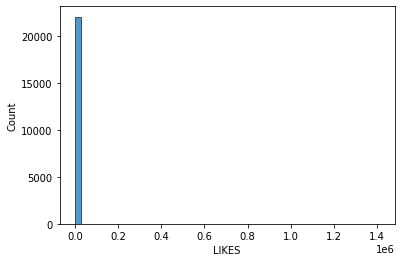

In [1012]:
sns.histplot(x = df.LIKES,bins=50)

In [1013]:
bins_LIKES=[min(df.LIKES)-1,15,40,200,400,max(df.LIKES)+1]
pd.cut(x=df.LIKES, bins=5).value_counts()
pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
       ordered=True).value_counts()

High         9720
Medium       5043
Low          3628
Extreme      1964
Very High    1768
Name: LIKES, dtype: int64

In [1014]:
df['LIKES_RANK'] = pd.cut(x=df.LIKES, bins=bins_LIKES, labels=bin_labels,
       ordered=True)

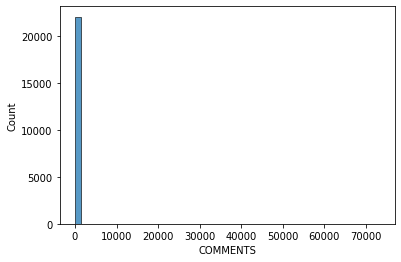

In [1015]:
sns.histplot(x = df.COMMENTS,bins=50)

In [1016]:
len(df.COMMENTS) #3921

22123

In [1017]:
bins_COMMENTS=[min(df.COMMENTS)-1,1,5,40,60,max(df.COMMENTS)]
#pd.cut(x=df.COMMENTS, bins=5).value_counts()
pd.cut(x=df.COMMENTS, bins=bins_COMMENTS#, labels=labels 
        ,ordered=True).value_counts()

(-1, 1]        8394
(5, 40]        6627
(1, 5]         5700
(60, 73188]     818
(40, 60]        584
Name: COMMENTS, dtype: int64

In [1018]:
df['COMMENTS_RANK'] = pd.cut(x=df.COMMENTS, bins=bins_COMMENTS, labels=bin_labels 
        ,ordered=True)

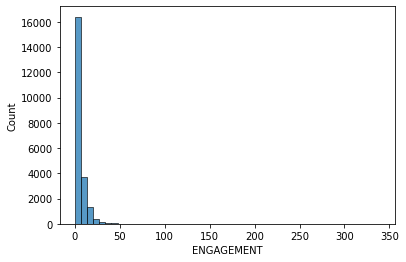

In [1019]:
sns.histplot(x = df.ENGAGEMENT,bins=50)

In [1020]:
bins_ENGAGEMENT=[min(df.ENGAGEMENT)-1,1.5,3.5,10,15,max(df.ENGAGEMENT)]
pd.cut(x=df.ENGAGEMENT, bins=5, labels=bin_labels, ordered=True).value_counts()
pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True).value_counts()

High         6857
Low          6365
Medium       5495
Very High    1767
Extreme      1639
Name: ENGAGEMENT, dtype: int64

In [1021]:
df['ENGAGEMENT_RANK'] = pd.cut(x=df.ENGAGEMENT, bins=bins_ENGAGEMENT, labels=bin_labels, ordered=True)

In [1022]:
df['ENGAGEMENT_RANK']

LINE_NUM_INDEX
1918      Medium
1920     Extreme
1922        High
1929        High
1930        High
          ...   
35893        Low
35916        Low
36397        Low
36489        Low
37546        Low
Name: ENGAGEMENT_RANK, Length: 22123, dtype: category
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

Convert Rank to Code using Dictionary 

In [1023]:
df.columns

Index(['FOLLOWER', 'LIKES', 'COMMENTS', 'ENGAGEMENT', 'ACCESSIBILITY_CAPTION',
       'CAPTION', 'LOCATION', 'CITY', 'COUNTRY', 'IMAGE_LABELS',
       'CAPTION_INTEREST', 'ACCESSIBILITY_CAPTION_INTEREST',
       'IMAGE_LABEL_INTEREST', 'COMMENT_DISABLED', 'IS_VIDEO', 'HAS_AUDIO',
       'log_ENGAGEMENT', 'log_LIKES', 'log_COMMENTS', 'DATETIME', 'YEAR',
       'MONTH', 'DAY', 'DAYOFWEEK', 'HOUR', 'MINUTE',
       'NUMBER_OF_WORDS_IN_CAPTION', 'NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_CAPTION', 'NUMBER_OF_HASH_IN_CAPTION',
       'NUMBER_OF_AT_IN_CAPTION', 'NUMBER_OF_COMMA_IN_CAPTION',
       'NUMBER_OF_WORDS_IN_ACCESSIBILITY_CAPTIONN',
       'NUMBER_OF_EXCLAMATION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_QUESTION_MARK_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_HASH_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_AT_IN_ACCESSIBILITY_CAPTION',
       'NUMBER_OF_COMMA_IN_ACCESSIBILITY_CAPTION', 'LIKES_RANK',
       'COMMENTS_RANK', 'ENGAGEMENT_RAN

In [1024]:
df.LIKES_RANK.unique()

['Medium', 'High', 'Low', 'Very High', 'Extreme']
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

In [1025]:
df['COMMENTS_RANK']

LINE_NUM_INDEX
1918        Low
1920     Medium
1922     Medium
1929     Medium
1930       High
          ...  
35893       Low
35916       Low
36397       Low
36489       Low
37546       Low
Name: COMMENTS_RANK, Length: 22123, dtype: category
Categories (5, object): ['Low' < 'Medium' < 'High' < 'Very High' < 'Extreme']

In [1026]:
map_dict_rank = {'Low':0.0 , 'Medium':1.0, 'High':2.0, 'Very High':3.0, 'Extreme':4.0}
map_dict_rank

{'Extreme': 4.0, 'High': 2.0, 'Low': 0.0, 'Medium': 1.0, 'Very High': 3.0}

In [1027]:
df['LIKES_RANK_INT'] =  df['LIKES_RANK'].map(map_dict_rank).astype(int)

In [1028]:
df['COMMENTS_RANK_INT'] =   df['COMMENTS_RANK'].map(map_dict_rank).astype(int)

In [1029]:
df['ENGAGEMENT_RANK_INT'] =   df['ENGAGEMENT_RANK'].map(map_dict_rank).astype(int)

In [1030]:
df[['LIKES_RANK','LIKES_RANK_INT']].value_counts().sort_index()

LIKES_RANK  LIKES_RANK_INT
Low         0                 3628
Medium      1                 5043
High        2                 9720
Very High   3                 1768
Extreme     4                 1964
dtype: int64

In [1031]:
df[['COMMENTS_RANK','COMMENTS_RANK_INT']].value_counts().sort_index()

COMMENTS_RANK  COMMENTS_RANK_INT
Low            0                    8394
Medium         1                    5700
High           2                    6627
Very High      3                     584
Extreme        4                     818
dtype: int64

In [1032]:
df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_INT']].value_counts().sort_index()

ENGAGEMENT_RANK  ENGAGEMENT_RANK_INT
Low              0                      6365
Medium           1                      5495
High             2                      6857
Very High        3                      1767
Extreme          4                      1639
dtype: int64

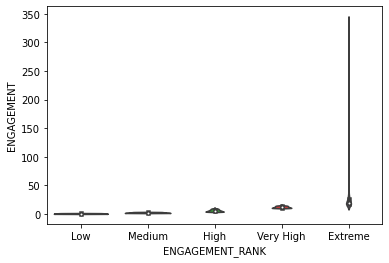

In [1033]:
p = sns.violinplot(x='ENGAGEMENT_RANK', y='ENGAGEMENT', 
                    #order=cut_order, 
                    data=df)

## Eladk 28-Sep-2021, more bucketing



1.  VIDEO_VIEW_COUNT          41.148879
2.  FOLLOWER                  35.852012
3.  USERNAME_OBJECT_AS_INT    17.961764
4.  CAPTION_OBJECT_AS_INT      3.558228
5.  HOUR                       1.201713
6.  MINUTE                     0.277403



In [ ]:
df.FOLLOWER.value_counts().sort_values(ascending=False).plot.bar()
#.reindex()

## Replacing Charecters  with Number uning OrdinalEncoder

In [ ]:
# list of char / object columns

In [ ]:
df.dtypes

In [ ]:
df.select_dtypes(include=['object']).dtypes

In [ ]:
df.select_dtypes(include=['object']).dtypes.index

In [ ]:
df.info()

In [ ]:
enc = OrdinalEncoder()

Many columns:

In [ ]:
for col in df.select_dtypes(include=['object']).dtypes.index:
#for col in ['USERNAME','FULLNAME']:
  #col_list = pd.DataFrame(df[col].unique())
  #col_list.rename(columns = {0:col},inplace=True)
  #col_list.rename(columns = {0:col},inplace=True)
  enc.fit(df[[col]])
  df[col + '_OBJECT_AS_INT'] = enc.transform(df[[col]])
  #print(col)

In [ ]:
df.info()

In [ ]:
df.head(2)

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Relationship Between The Features of The instagram Data")
sns.heatmap(df.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [ ]:
# %%time 
# df = df.select_dtypes(include=np.number)
# sns.pairplot(df ,height=1.8) # takes about 5 min.

## More EDA

In [ ]:
df.head(2)

## Feature Engneering

## Image captioning

Eladk 2021-Sep-17, we need to:


*   convert y colum to 5 classes so we can have a classification problem and not a regresion model
*   check if the data is inbalance (so we need to use stratify)



# Split the Data for image or video post

In [ ]:
df.info()

In [ ]:
df_image = df[df['IS_VIDEO'] == 'no']
df_image.info()

In [ ]:
df_video = df[df['IS_VIDEO']=='yes']
df_video.info()

# Split the Data for modules

select only int and float column types to X 
seletc LIKES, COMMENTS, ENGAGEMENT as y

In [ ]:
df_image.columns

In [ ]:
df_video.columns

In [ ]:
X = df.select_dtypes(include=['number'])
X.drop(['LIKES','COMMENTS','ENGAGEMENT','log_ENGAGEMENT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
X.drop(['LIKES_RANK_INT','COMMENTS_RANK_INT','ENGAGEMENT_RANK_INT'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
X.drop(['log_LIKES','log_COMMENTS'], axis=1, inplace=True) #['LIKES','COMMENTS','ENGAGEMENT']

In [ ]:
df_video.columns

In [ ]:
y = df['ENGAGEMENT']
y1 = df['LIKES']
y2 = df['COMMENTS']
y3 = df['log_ENGAGEMENT']
y_ENGAGEMENT_RANK_INT = df['ENGAGEMENT_RANK_INT']
y_LIKES_RANK_INT = df['LIKES_RANK_INT']
y_COMMENTS_RANK_INT = df['COMMENTS_RANK_INT']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y3, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Labels (y) Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels(y) Shape:', y_test.shape)

# Mechine Learning  Model for df_image

## Appling First1 Model - KNN model

In [ ]:
rmse_val = [] #to store rmse values for different k
for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = (mse(y_test,pred))**0.5 #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

In [ ]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [ ]:
min_mse_k = min(rmse_val)
min_index = rmse_val.index(min_mse_k)
print(min_index, min_mse_k)

In [ ]:
neighbor = min_index
knn_model_1 = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train, y_train)

In [ ]:
y_train_pred = knn_model_1.predict(X_train)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(y_train[-150:]))), y=y_train[-150:],
                         mode='lines',
                         name='Prediction'))
fig.add_trace(go.Scatter(x=list(range(len(y_train_pred[-150:]))), y=y_train_pred[-150:],
                         mode='lines',
                         name='True value'))

fig.show()

## Validating the Model 

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
y_test_pred = knn_model_1.predict(X_test)
ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
print('RMSE ', RMSE)

print('r2_score: ', round(r2_score(y_test, y_test_pred)*100, 2))

## Scaled MaxAbsScaler model

In [ ]:
my_scaler = MaxAbsScaler().fit(X_train)
X_train_scaled = pd.DataFrame(my_scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.head()

In [ ]:
knn_model_2 = KNeighborsRegressor(n_neighbors=10).fit(X_train_scaled, y_train)

In [ ]:
y_train_pred = knn_model_2.predict(X_train_scaled)

In [ ]:
ax = sns.scatterplot(x=y_train, y=y_train_pred)
ax.plot(y_train, y_train, 'r')

In [ ]:
RMSE = mse(y_train, y_train_pred)**0.5
RMSE

In [ ]:
X_test_scaled = my_scaler.transform(X_test)
y_test_pred = knn_model_2.predict(X_test_scaled)

ax = sns.scatterplot(x=y_test, y=y_test_pred)
ax.plot(y_test, y_test, 'r')

In [ ]:
RMSE = mse(y_test, y_test_pred)**0.5
RMSE

## Appling 2nd Model - Decision Tree with bins

In [ ]:
# model_2_dt = DecisionTreeClassifier(
#     min_samples_leaf=3
#     ,max_depth=5
#     )

In [ ]:
model_2_dt_pred_like = DecisionTreeClassifier(
    min_samples_leaf=3
    ,max_depth=5
    )

In [ ]:
model_2_dt_pred_comments = DecisionTreeClassifier(
    min_samples_leaf=3
    ,max_depth=5
    )

In [ ]:
X.columns

In [ ]:
# model_2_dt.fit(X, 
#               y_ENGAGEMENT_RANK_INT)

In [ ]:
model_2_dt_pred_like.fit(X, 
              y_LIKES_RANK_INT)

In [ ]:
model_2_dt_pred_comments.fit(X, 
              y_COMMENTS_RANK_INT)

In [ ]:
class_list = [str(x) for x in model_2_dt_pred_comments.classes_]
class_list

In [ ]:
dot_data = StringIO()  
export_graphviz(model_2_dt_pred_like, out_file=dot_data, feature_names=X.columns, 
                leaves_parallel=True, filled=True, class_names=[str(x) for x in model_2_dt_pred_like.classes_])
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

In [ ]:
dot_data = StringIO()  
export_graphviz(model_2_dt_pred_comments, out_file=dot_data, feature_names=X.columns, 
                leaves_parallel=True, filled=True, class_names=[str(x) for x in model_2_dt_pred_comments.classes_])
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
Image(graph.create_png(), width=1000) 

View Features Emportance:

In [ ]:
pd.Series(model_2_dt_pred_like.feature_importances_*100,
          index=X.columns).sort_values(ascending=False).round()

In [906]:
pd.Series(model_2_dt_pred_comments.feature_importances_*100,
          index=X.columns).sort_values(ascending=False).round()

FOLLOWER                                        56.0
CAPTION_INTEREST_OBJECT_AS_INT                  12.0
ACCESSIBILITY_CAPTION_OBJECT_AS_INT             10.0
NUMBER_OF_WORDS_IN_CAPTION                       8.0
NUMBER_OF_QUESTION_MARK_IN_CAPTION               6.0
MONTH                                            3.0
YEAR                                             1.0
IMAGE_LABEL_INTEREST_OBJECT_AS_INT               1.0
COMMENT_DISABLED                                 1.0
DAY                                              0.0
CITY_OBJECT_AS_INT                               0.0
IMAGE_LABELS_OBJECT_AS_INT                       0.0
MINUTE                                           0.0
NUMBER_OF_HASH_IN_CAPTION                        0.0
ACCESSIBILITY_CAPTION_INTEREST_OBJECT_AS_INT     0.0
NUMBER_OF_EXCLAMATION_MARK_IN_CAPTION            0.0
LOCATION_OBJECT_AS_INT                           0.0
HOUR                                             0.0
DAYOFWEEK                                     

Eladk 2021-Sep-24 comment in first model:

*   Why Time is So meaning full?
*   What ACCESSIBILITY_CAPTION have corolation with ranking?
*   I Need to understand why folloer is very meaningfull
*   I Need to understand why USERNAME,userid is very meaningfull

In [ ]:
df.head(3)

In [ ]:
df['LIKES_RANK_INT_pred'] = model_2_dt_pred_like.predict(X)
df.head(1)

In [ ]:
df['COMMENTS_RANK_INT_pred'] = model_2_dt_pred_comments.predict(X)
df.head(1)

In [ ]:
s = pd.Series(model_2_dt_pred_like.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

In [ ]:
s = pd.Series(model_2_dt_pred_comments.feature_importances_*100,
          index=X.columns).sort_values(ascending=False)

s[s.gt(0)]

In [ ]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))
# map_dict_ENGAGEMENT

In [ ]:
#df['ENGAGEMENT_RANK_pred'] = df['ENGAGEMENT_RANK_INT_pred'].map(map_dict_ENGAGEMENT)

Evanuating the Model:

In [ ]:
#type(df[['ENGAGEMENT_RANK','ENGAGEMENT_RANK_pred']].value_counts())

In [ ]:
df[['LIKES_RANK_INT','LIKES_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
df[['COMMENTS_RANK_INT','COMMENTS_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
cm = confusion_matrix(y_true=df.LIKES_RANK_INT,
                      y_pred=df.LIKES_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt.classes_,
             columns=model_2_dt.classes_)

In [ ]:
cm = confusion_matrix(y_true=df.COMMENTS_RANK_INT,
                      y_pred=df.COMMENTS_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt.classes_,
             columns=model_2_dt.classes_)

In [ ]:
print(classification_report(y_true=df.LIKES_RANK_INT,
                      y_pred=df.LIKES_RANK_INT_pred))

In [ ]:
print(classification_report(y_true=df.COMMENTS_RANK_INT,
                      y_pred=df.COMMENTS_RANK_INT_pred))

In [ ]:
accuracy_score(y_true=df.LIKES_RANK_INT, y_pred=df.LIKES_RANK_INT_pred)

In [ ]:
accuracy_score(y_true=df.COMMENTS_RANK_INT, y_pred=df.COMMENTS_RANK_INT_pred)

In [ ]:
# s = pd.Series(model_2_dt_pred_comments.feature_importances_*100,
#           index=X.columns).sort_values(ascending=False)

# s[s.gt(0)]

In [ ]:
# p = sns.violinplot(x='ENGAGEMENT_RANK', y='HOUR', 
#                     #order=cut_order, 
#                     data=df)

In [ ]:
# for index, val in pd.Series(model_2_dt.feature_importances_*100,index=X.columns).iteritems():
#   if val > 0:
#     plt.figure()
#     p = sns.violinplot(x='ENGAGEMENT_RANK', y=index, 
#                     #order=cut_order, 
#                     data=df)
    

## Scoring 

## Appling 3nd Model - Random Forest regression

In [ ]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = rand_state)
# Train the model on training data
rf.fit(X_train, y_train);

In [ ]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(rf_predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'log_of_enegament.')

In [ ]:
ax = sns.scatterplot(x=y_test, y=rf_predictions)
ax.plot(y_train, y_train, 'r')

In [ ]:
x = np.linspace(0, len(y_test), len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x, y_test, label='y_test')
plt.plot(x, rf_predictions, label='y_prep')
plt.xlabel('index')
plt.ylabel('log_engament')
plt.legend()
plt.show()

In [ ]:
rf_y_train_pred = rf.predict(X_train)
RMSE = mse(y_train, rf_y_train_pred)**0.5
RMSE

In [ ]:
rf_y_test_pred = rf.predict(X_test)
RMSE = mse(y_test, rf_y_test_pred)**0.5
RMSE


In [ ]:
pd.Series(rf.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)

In [ ]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [20, 35, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
#Model Performance
#Average Error: 3.6561 degrees.
#Accuracy = 93.83%.
#print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))
#Improvement of 0.50%.

In [ ]:
grid_search.best_params_

## Appling 4nd Model - Random Forest Classification 

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_LIKES_RANK_INT, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, y_COMMENTS_RANK_INT, train_size = train_size\
                           , random_state = rand_state)#, stratify = df.ENGAGEMENT)

In [ ]:
X_train_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)
X_test_4.drop(columns='VIDEO_VIEW_COUNT', inplace=True)

In [ ]:
X_train_4.columns

In [ ]:
model_rf_4 = RandomForestClassifier()

model_rf_4.fit(X_train_4,y_train_4) # X_test_4 is Engagment_rank
preds= model_rf_4.predict_proba(X_train_4)[:,1]

#roc_auc_score(y_test_4,preds)

In [ ]:
# map_dict_ENGAGEMENT = dict(zip(df.ENGAGEMENT_RANK_INT,df.ENGAGEMENT_RANK))

In [ ]:
pd.Series(model_rf_4.feature_importances_*100, index=X_train_4.columns).sort_values(ascending=False).round()#.plot.barh(figsize=(14,12))

In [ ]:
from sklearn import tree

In [ ]:
import six

In [ ]:
_ = tree.plot_tree(model_rf_4.estimators_[0], feature_names=X_train_4.columns, filled=True)

In [ ]:
X_train_4.columns

In [ ]:
X_train_4.head(3)

In [ ]:
X_train_4['y_ENGAGEMENT_RANK_INT_pred_rf'] = model_rf_4.predict(X_train_4)

In [ ]:
X_train_4.head(3)

In [ ]:
X_train_4 = pd.concat([X_train_4, y_train_4], axis=1).reset_index()

In [ ]:
X_train_4.head(3)

In [ ]:
print(len(X_train_4))

In [ ]:
len(X_train_4[X_train_4.y_ENGAGEMENT_RANK_INT_pred_rf == X_train_4.ENGAGEMENT_RANK_INT])

In [ ]:
cm = confusion_matrix(y_true=y_train_4,
                      y_pred=X_train_4['y_ENGAGEMENT_RANK_INT_pred_rf'])
pd.DataFrame(cm,
             index=model_rf_4.classes_,
             columns=model_rf_4.classes_)

In [ ]:
X_train_4.columns

In [ ]:
print(classification_report(y_true=y_train_4,
                      y_pred=X_train_4.y_ENGAGEMENT_RANK_INT_pred_rf))

**WTF!!!**

In [ ]:
print(classification_report(y_true=df.ENGAGEMENT_RANK_INT,
                      y_pred=df.ENGAGEMENT_RANK_INT_pred))

In [ ]:
X_test_4.columns

In [ ]:
X_test_4.head(3)

In [ ]:
X_test_4['y_ENGAGEMENT_RANK_INT_pred'] = model_rf_4.predict(X_test_4)

In [ ]:
X_test_4.head(3)

In [ ]:
#pd.concat([X_test_4, df4.reindex(df1.index)], axis=1)
X_test_4 = pd.concat([X_test_4, y_test_4], axis=1).reindex(X_test_4.index)

In [ ]:
X_test_4.head(3)

In [ ]:
X_test_4[['ENGAGEMENT_RANK_INT','y_ENGAGEMENT_RANK_INT_pred']].value_counts().sort_index()

In [ ]:
cm = confusion_matrix(y_true=X_test_4.ENGAGEMENT_RANK_INT,
                      y_pred=X_test_4.y_ENGAGEMENT_RANK_INT_pred)
pd.DataFrame(cm,
             index=model_2_dt.classes_,
             columns=model_2_dt.classes_)

In [ ]:
print(classification_report(y_test_4,
                      y_pred=X_test_4.y_ENGAGEMENT_RANK_INT_pred))

Visualize the Random Forest:

In [ ]:
# dotfile = six.StringIO()
# i_tree = 0
# for tree_in_forest in model_rf_4.estimators_:
#   if (i_tree <1):        
#       export_graphviz(model_rf_4,
#                   feature_names=X_train_4.columns,
#                   filled=True,
#                   rounded=True)
#       pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png('dtree'+ str(i_tree) +'.png')
#       i_tree = i_tree + 1

## Appling 4nd Model - XGBoost regression


In [ ]:
XGB_reg = xgb.XGBRegressor()

In [ ]:
print(XGB_reg)

In [ ]:
XGB_reg.fit(X_train, y_train)

In [ ]:
score = XGB_reg.score(X_train, y_train)  
print("Training score: ", score)

In [ ]:
scores = cross_val_score(XGB_reg, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

In [ ]:
y_test_pred = XGB_reg.predict(X_test)
mse = mse(y_test, y_test_pred)
score_test = XGB_reg.score(X_test, y_test)  
print("Training score: ", score_test)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**0.5))


In [ ]:
x_ax = range(len(y_test))
fig = plt.figure(figsize=(9, 10))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_test_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()

In [ ]:
XGB_param_grid = {'colsample_bytree': [0.3, 0.7, 1.0, 1.2],
    'n_estimators': [50,100,200],    'max_depth': [2,3,4]
}
XGB_reg_grid = xgb.XGBRegressor()
grid_mse = GridSearchCV(param_grid=XGB_param_grid, estimator=XGB_reg_grid, 
                        scoring='neg_mean_squared_error', cv=4, verbose=1)
grid_mse.fit(X, y)
# Print the best parameters and lowest RMSE
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))